# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

Using TensorFlow backend.


In [2]:
np.random.seed(0)

# GLOBAL VARS

In [25]:
INDIVIDUALS = 50
P_CROSS = 0.8
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [11]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [12]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [14]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("../../Models/CNN_CIFAR10_net3.h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [15]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=1):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



In [23]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  pop.append(uniform(parent1,parent2))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  
def uniform(p1, p2):
    for i in range(1024):
        if np.random.uniform() > P_CROSS:
            a = p1[i]
            p1[i] = p2[i]
            p2[i] = a
    return p1, p2


In [18]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [19]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [0]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Generation 0
Max fitness value -0.5997851650204091
Generation 10
Max fitness value -0.5329512420649721
Generation 20
Max fitness value 0.9607891495034024
Generation 30
Max fitness value 0.9755418796247006
Generation 40
Max fitness value 0.9765218821523239
Generation 50
Max fitness value 0.9778710976188695
Generation 60
Max fitness value 0.9778710976188695
Generation 70
Max fitness value 0.9778710976188695
Generation 80
Max fitness value 0.9784017112159664
Generation 90
Max fitness value 0.9784017112159664
Generation 100
Max fitness value 0.9784017112159664
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


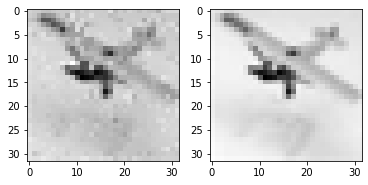

True label: 0
predicted label: 4
Time:  390.01768231391907  seconds
Generation 0
Max fitness value -0.11821834569991924
Generation 10
Max fitness value 0.9604267139254016
Generation 20
Max fitness value 0.9942655226905125
Generation 30
Max fitness value 0.9956782701082385
Generation 40
Max fitness value 0.9956782701082385
Generation 50
Max fitness value 0.9958266072089601
Generation 60
Max fitness value 0.9958266072089601
Generation 70
Max fitness value 0.9958266072089601
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


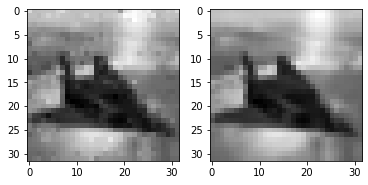

True label: 0
predicted label: 8
Time:  276.4232165813446  seconds
Generation 0
Max fitness value 0.35613327374758186
Generation 10
Max fitness value 0.9899152818965573
Generation 20
Max fitness value 0.9933353656352695
Generation 30
Max fitness value 0.9933740726940488
Generation 40
Max fitness value 0.9934280689871947
Generation 50
Max fitness value 0.9934280689871947
Generation 60
Max fitness value 0.9934280689871947
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


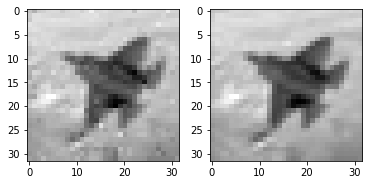

True label: 0
predicted label: 2
Time:  249.7217094898224  seconds
Generation 0
Max fitness value -0.5722021946166261
Generation 10
Max fitness value 0.8319190756214943
Generation 20
Max fitness value 0.9916410330827146
Generation 30
Max fitness value 0.9932253208336437
Generation 40
Max fitness value 0.9938872051213025
Generation 50
Max fitness value 0.9944112024837678
Generation 60
Max fitness value 0.9945285116706355
Generation 70
Max fitness value 0.9947777993102843
Generation 80
Max fitness value 0.9950015408938616
Generation 90
Max fitness value 0.9951616515992834
Generation 100
Max fitness value 0.9951616515992834
Generation 110
Max fitness value 0.9951616515992834
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


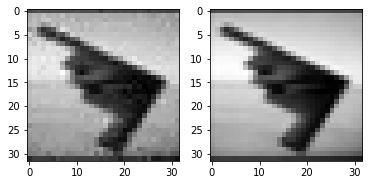

True label: 0
predicted label: 2
Time:  447.48266673088074  seconds
Generation 0
Max fitness value 0.06216579488578121
Generation 10
Max fitness value 0.9539103162134557
Generation 20
Max fitness value 0.9646182485288188
Generation 30
Max fitness value 0.9662296273139641
Generation 40
Max fitness value 0.9667815023699377
Generation 50
Max fitness value 0.9670010545797003
Generation 60
Max fitness value 0.9670010545797003
Generation 70
Max fitness value 0.9670010545797003
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


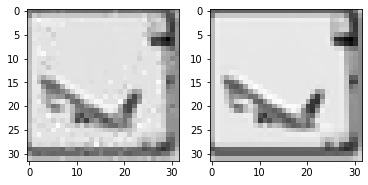

True label: 0
predicted label: 2
Time:  283.8666081428528  seconds
Generation 0
Max fitness value -0.562608723311687
Generation 10
Max fitness value 0.9186176358202978
Generation 20
Max fitness value 0.9328579992539432
Generation 30
Max fitness value 0.9351833722013592
Generation 40
Max fitness value 0.9357715357268195
Generation 50
Max fitness value 0.9357715357268195
Generation 60
Max fitness value 0.9357715357268195
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


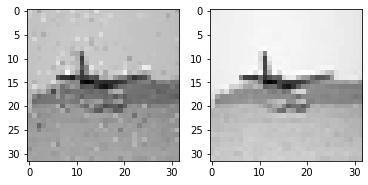

True label: 0
predicted label: 8
Time:  242.56019568443298  seconds
Generation 0
Max fitness value -0.5997727829426718
Generation 10
Max fitness value -0.5997727829426718
Generation 20
Max fitness value -0.39528582499122306
Generation 30
Max fitness value 0.9101715530461025
Generation 40
Max fitness value 0.9698591804932237
Generation 50
Max fitness value 0.9723369126983609
Generation 60
Max fitness value 0.9739794031817502
Generation 70
Max fitness value 0.9754295363796176
Generation 80
Max fitness value 0.9754295363796176
Generation 90
Max fitness value 0.9754295363796176
Generation 100
Max fitness value 0.9758600415360916
Generation 110
Max fitness value 0.9762896944852457
Generation 120
Max fitness value 0.9762896944852457
Generation 130
Max fitness value 0.9762974380667524
Generation 140
Max fitness value 0.9762974380667524
Generation 150
Max fitness value 0.9763778370646913
Generation 160
Max fitness value 0.9764751862233386
Generation 170
Max fitness value 0.9766022613025058
Gen

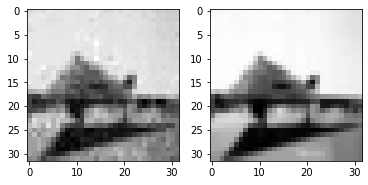

True label: 0
predicted label: 8
Time:  776.4305956363678  seconds
Generation 0
Max fitness value -0.5834850348197431
Generation 10
Max fitness value 0.5149024871518629
Generation 20
Max fitness value 0.9914036801416308
Generation 30
Max fitness value 0.9948231076544904
Generation 40
Max fitness value 0.9954210396991032
Generation 50
Max fitness value 0.9956810146754712
Generation 60
Max fitness value 0.9957721192006309
Generation 70
Max fitness value 0.9958246207867865
Generation 80
Max fitness value 0.995856116602158
Generation 90
Max fitness value 0.995856116602158
Generation 100
Max fitness value 0.995856116602158
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


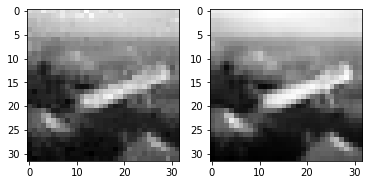

True label: 0
predicted label: 8
Time:  388.3940398693085  seconds
Generation 0
Max fitness value -0.5210317612505916
Generation 10
Max fitness value 0.6445454590595154
Generation 20
Max fitness value 0.9867063757592063
Generation 30
Max fitness value 0.9898804898500441
Generation 40
Max fitness value 0.9911056974093817
Generation 50
Max fitness value 0.9915662159978564
Generation 60
Max fitness value 0.9917588471468366
Generation 70
Max fitness value 0.9920007740457428
Generation 80
Max fitness value 0.9920007740457428
Generation 90
Max fitness value 0.9920007740457428
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


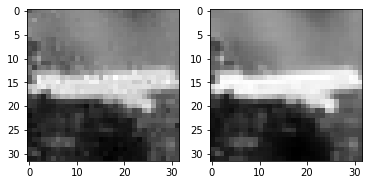

True label: 0
predicted label: 8
Time:  371.76357889175415  seconds
Generation 0
Max fitness value 0.4744681109869234
Generation 10
Max fitness value 0.9817443959304034
Generation 20
Max fitness value 0.9823582368621442
Generation 30
Max fitness value 0.9823582368621442
Generation 40
Max fitness value 0.9823582368621442
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


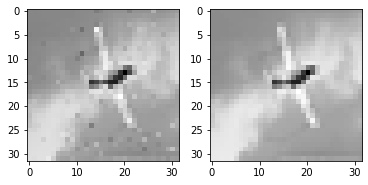

True label: 0
predicted label: 2
Time:  168.2013864517212  seconds
Generation 0
Max fitness value -0.05252042999313816
Generation 10
Max fitness value 0.9949383237840432
Generation 20
Max fitness value 0.9971451955254858
Generation 30
Max fitness value 0.9975308272013425
Generation 40
Max fitness value 0.9975308272013425
Generation 50
Max fitness value 0.9975308272013425
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


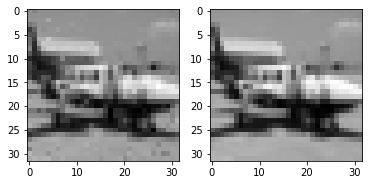

True label: 0
predicted label: 9
Time:  216.667475938797  seconds
Generation 0
Max fitness value 0.7863927815900207
Generation 10
Max fitness value 0.9942679836606234
Generation 20
Max fitness value 0.9947696069722609
Generation 30
Max fitness value 0.9950878284279185
Generation 40
Max fitness value 0.9950878284279185
Generation 50
Max fitness value 0.9950878284279185
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


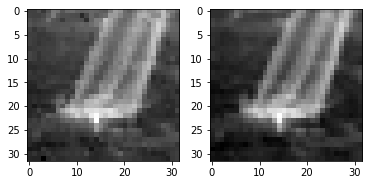

True label: 0
predicted label: 2
Time:  205.18155527114868  seconds
Generation 0
Max fitness value 0.6117536767316831
Generation 10
Max fitness value 0.9957611298970946
Generation 20
Max fitness value 0.9965023918355649
Generation 30
Max fitness value 0.996863507822949
Generation 40
Max fitness value 0.9968824502622268
Generation 50
Max fitness value 0.9969519415038118
Generation 60
Max fitness value 0.997014625430101
Generation 70
Max fitness value 0.997014625430101
Generation 80
Max fitness value 0.9970259148670044
Generation 90
Max fitness value 0.9970259148670044
Generation 100
Max fitness value 0.9970259148670044
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


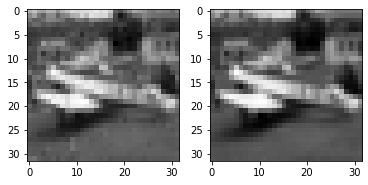

True label: 0
predicted label: 8
Time:  396.2818477153778  seconds
Generation 0
Max fitness value -0.6000120623230896
Generation 10
Max fitness value -0.6000120623230896
Generation 20
Max fitness value -0.2996988130919908
Generation 30
Max fitness value 0.9738215319004052
Generation 40
Max fitness value 0.9868510568010769
Generation 50
Max fitness value 0.9879351588786935
Generation 60
Max fitness value 0.9885566296528782
Generation 70
Max fitness value 0.9890566815667516
Generation 80
Max fitness value 0.9892615728661365
Generation 90
Max fitness value 0.989517754781814
Generation 100
Max fitness value 0.989517754781814
Generation 110
Max fitness value 0.9897429155025976
Generation 120
Max fitness value 0.9897705082559163
Generation 130
Max fitness value 0.9898210737741543
Generation 140
Max fitness value 0.9898210737741543
Generation 150
Max fitness value 0.9898210737741543
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: g

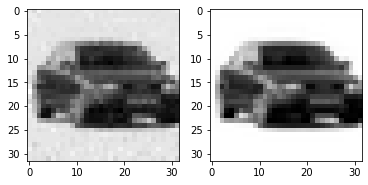

True label: 1
predicted label: 8
Time:  570.9503977298737  seconds
Generation 0
Max fitness value -0.0023239142686988234
Generation 10
Max fitness value 0.9956946630117243
Generation 20
Max fitness value 0.9978045259513575
Generation 30
Max fitness value 0.9979208922944006
Generation 40
Max fitness value 0.9979567723250741
Generation 50
Max fitness value 0.9979567723250741
Generation 60
Max fitness value 0.9979685288357396
Generation 70
Max fitness value 0.9979685288357396
Generation 80
Max fitness value 0.9979685288357396
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


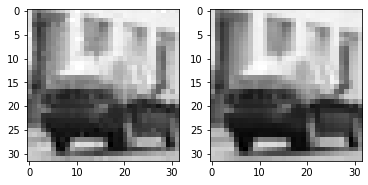

True label: 1
predicted label: 9
Time:  312.0165801048279  seconds
Generation 0
Max fitness value -0.6000009086007678
Generation 10
Max fitness value -0.6000009086007678
Generation 20
Max fitness value -0.6000009086007678
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


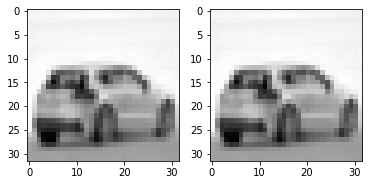

True label: 1
predicted label: 1
Time:  130.13790583610535  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.77903699428103
Generation 0
Max fitness value 0.861656247958422
Generation 10
Max fitness value 0.9970009328179751
Generation 20
Max fitness value 0.9976217258663983
Generation 30
Max fitness value 0.9976217258663983
Generation 40
Max fitness value 0.9976217258663983
Generation 50
Max fitness value 0.9976217258663983
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


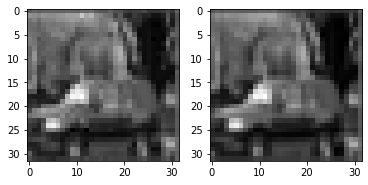

True label: 1
predicted label: 7
Time:  279.8105754852295  seconds
Generation 0
Max fitness value 0.8224489330213408
Generation 10
Max fitness value 0.9923091352756584
Generation 20
Max fitness value 0.9949089945514642
Generation 30
Max fitness value 0.9953541951627932
Generation 40
Max fitness value 0.9953541951627932
Generation 50
Max fitness value 0.9953541951627932
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


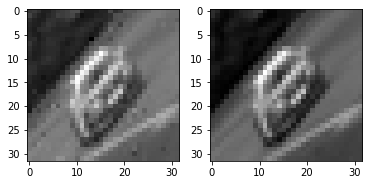

True label: 1
predicted label: 6
Time:  299.55476450920105  seconds
Generation 0
Max fitness value -0.5053934829462752
Generation 10
Max fitness value 0.9885546212497323
Generation 20
Max fitness value 0.9958148863524277
Generation 30
Max fitness value 0.9961491764205844
Generation 40
Max fitness value 0.9962006803378414
Generation 50
Max fitness value 0.9962006803378414
Generation 60
Max fitness value 0.9962006803378414
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


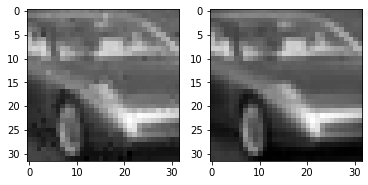

True label: 1
predicted label: 0
Time:  332.15672612190247  seconds
Generation 0
Max fitness value -0.6000024814573579
Generation 10
Max fitness value -0.6000024814573579
Generation 20
Max fitness value -0.6000024814573579
Generation 30
Max fitness value -0.5437804922151485
Generation 40
Max fitness value 0.8868783082871762
Generation 50
Max fitness value 0.9859532483287066
Generation 60
Max fitness value 0.9946416530818886
Generation 70
Max fitness value 0.99630105128469
Generation 80
Max fitness value 0.9968222269602788
Generation 90
Max fitness value 0.9969725270831947
Generation 100
Max fitness value 0.9970129111802287
Generation 110
Max fitness value 0.997107553862217
Generation 120
Max fitness value 0.9972094416903673
Generation 130
Max fitness value 0.9973198248940501
Generation 140
Max fitness value 0.9974248098442416
Generation 150
Max fitness value 0.9974957313637843
Generation 160
Max fitness value 0.9975183261719659
Generation 170
Max fitness value 0.9975827627223182
Genera

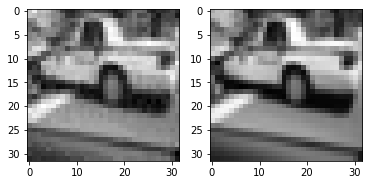

True label: 1
predicted label: 9
Time:  1597.243882894516  seconds
Generation 0
Max fitness value -0.6000007463353048
Generation 10
Max fitness value 0.9834422235890934
Generation 20
Max fitness value 0.9956109115806531
Generation 30
Max fitness value 0.9958774167863296
Generation 40
Max fitness value 0.9958774167863296
Generation 50
Max fitness value 0.996145847520071
Generation 60
Max fitness value 0.996145847520071
Generation 70
Max fitness value 0.996145847520071
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


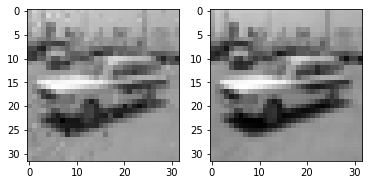

True label: 1
predicted label: 0
Time:  336.5909831523895  seconds
Generation 0
Max fitness value -0.600007206306256
Generation 10
Max fitness value -0.600007206306256
Generation 20
Max fitness value -0.600007206306256
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


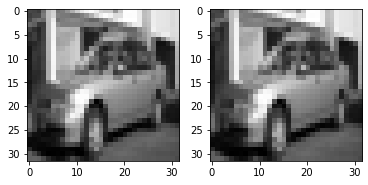

True label: 1
predicted label: 1
Time:  110.5781798362732  seconds
Generation 0
Max fitness value -0.593124889753686
Generation 10
Max fitness value 0.768306748336177
Generation 20
Max fitness value 0.9942048564598855
Generation 30
Max fitness value 0.9956502091876799
Generation 40
Max fitness value 0.9958409061504849
Generation 50
Max fitness value 0.9958409061504849
Generation 60
Max fitness value 0.9960484264185135
Generation 70
Max fitness value 0.9960498978233514
Generation 80
Max fitness value 0.9960498978233514
Generation 90
Max fitness value 0.9960498978233514
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


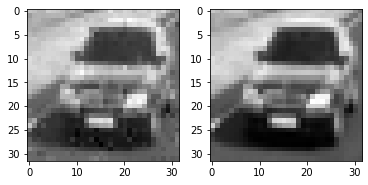

True label: 1
predicted label: 9
Time:  346.5540442466736  seconds
Generation 0
Max fitness value -0.6000185055982543
Generation 10
Max fitness value -0.6000185055982543
Generation 20
Max fitness value -0.6000185055982543
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


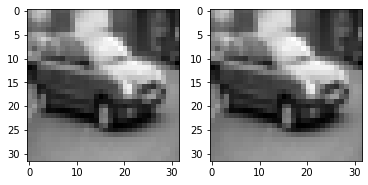

True label: 1
predicted label: 1
Time:  111.1186580657959  seconds
Generation 0
Max fitness value -0.6000301403759769
Generation 10
Max fitness value -0.6000301403759769
Generation 20
Max fitness value -0.6000301403759769
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


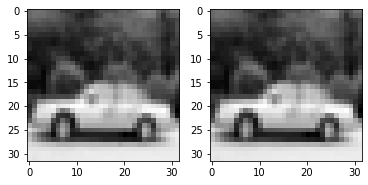

True label: 1
predicted label: 1
Time:  110.4407696723938  seconds
Generation 0
Max fitness value -0.5001874866114506
Generation 10
Max fitness value 0.9105364907763476
Generation 20
Max fitness value 0.9927542615740352
Generation 30
Max fitness value 0.994853612163715
Generation 40
Max fitness value 0.9951175369784584
Generation 50
Max fitness value 0.9954040942200915
Generation 60
Max fitness value 0.995535709363443
Generation 70
Max fitness value 0.9956903638391639
Generation 80
Max fitness value 0.9958297796438115
Generation 90
Max fitness value 0.99589857881928
Generation 100
Max fitness value 0.9959166175844079
Generation 110
Max fitness value 0.9959330291016855
Generation 120
Max fitness value 0.9959425757368168
Generation 130
Max fitness value 0.9959425757368168
Generation 140
Max fitness value 0.9959425757368168
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


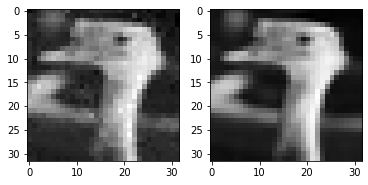

True label: 2
predicted label: 3
Time:  552.5552914142609  seconds
Generation 0
Max fitness value 0.9023933206889447
Generation 10
Max fitness value 0.995322962128779
Generation 20
Max fitness value 0.9960725947154954
Generation 30
Max fitness value 0.9960725947154954
Generation 40
Max fitness value 0.9960725947154954
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


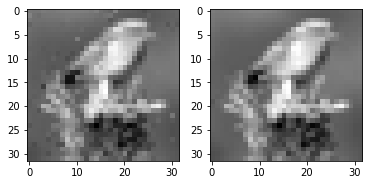

True label: 2
predicted label: 6
Time:  174.1134843826294  seconds
Generation 0
Max fitness value 0.38535047250994586
Generation 10
Max fitness value 0.9938888196440063
Generation 20
Max fitness value 0.9944671349024485
Generation 30
Max fitness value 0.9944671349024485
Generation 40
Max fitness value 0.9944671349024485
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


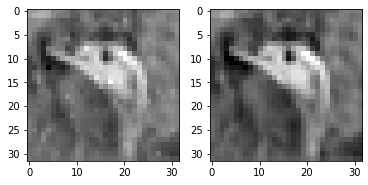

True label: 2
predicted label: 6
Time:  174.30524826049805  seconds
Generation 0
Max fitness value 0.07729687708414257
Generation 10
Max fitness value 0.9814964660652495
Generation 20
Max fitness value 0.9964875391211059
Generation 30
Max fitness value 0.997672080724813
Generation 40
Max fitness value 0.9977510495215154
Generation 50
Max fitness value 0.9977569531188928
Generation 60
Max fitness value 0.9978677952742869
Generation 70
Max fitness value 0.9979325008628455
Generation 80
Max fitness value 0.997937237510233
Generation 90
Max fitness value 0.997937237510233
Generation 100
Max fitness value 0.997937237510233
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


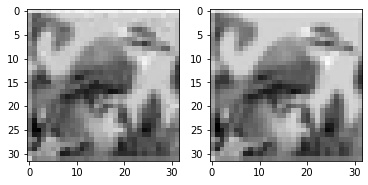

True label: 2
predicted label: 5
Time:  381.11550068855286  seconds
Generation 0
Max fitness value -0.5997048465089382
Generation 10
Max fitness value -0.56775906634488
Generation 20
Max fitness value 0.9167476970119028
Generation 30
Max fitness value 0.9884928018680792
Generation 40
Max fitness value 0.9900727113543032
Generation 50
Max fitness value 0.9910525869389042
Generation 60
Max fitness value 0.9913524263853283
Generation 70
Max fitness value 0.9913565185508691
Generation 80
Max fitness value 0.9919414942059308
Generation 90
Max fitness value 0.9920194571270461
Generation 100
Max fitness value 0.9921262885832162
Generation 110
Max fitness value 0.9923954438876333
Generation 120
Max fitness value 0.9923954438876333
Generation 130
Max fitness value 0.992653236141436
Generation 140
Max fitness value 0.9928718410008227
Generation 150
Max fitness value 0.9930411760028064
Generation 160
Max fitness value 0.9930411760028064
Generation 170
Max fitness value 0.9930411760028064
FITNESS 

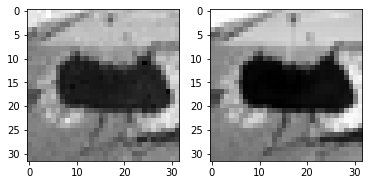

True label: 2
predicted label: 6
Time:  664.6183729171753  seconds
Generation 0
Max fitness value 0.5158936894784424
Generation 10
Max fitness value 0.9616671496360036
Generation 20
Max fitness value 0.9660325070498966
Generation 30
Max fitness value 0.9685231908541134
Generation 40
Max fitness value 0.9685231908541134
Generation 50
Max fitness value 0.9685231908541134
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


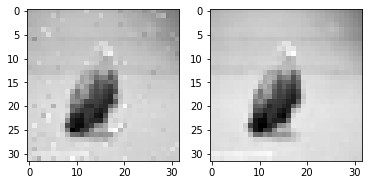

True label: 2
predicted label: 6
Time:  192.92861127853394  seconds
Generation 0
Max fitness value -0.5572741632373047
Generation 10
Max fitness value 0.9434937245852686
Generation 20
Max fitness value 0.9942643627404437
Generation 30
Max fitness value 0.9949241086554705
Generation 40
Max fitness value 0.9950717135374848
Generation 50
Max fitness value 0.9952256869195623
Generation 60
Max fitness value 0.9952256869195623
Generation 70
Max fitness value 0.9952390714402192
Generation 80
Max fitness value 0.9953409388635898
Generation 90
Max fitness value 0.9953500183029869
Generation 100
Max fitness value 0.9953500183029869
Generation 110
Max fitness value 0.9953500183029869
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


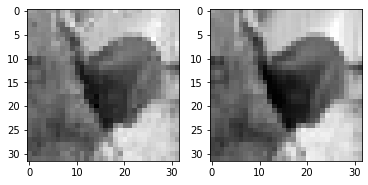

True label: 2
predicted label: 4
Time:  422.41452836990356  seconds
Generation 0
Max fitness value 0.18669969078558388
Generation 10
Max fitness value 0.9838018575077055
Generation 20
Max fitness value 0.9930813082439232
Generation 30
Max fitness value 0.9940806163145082
Generation 40
Max fitness value 0.9943212257820697
Generation 50
Max fitness value 0.9945663329156442
Generation 60
Max fitness value 0.9945663329156442
Generation 70
Max fitness value 0.9945663329156442
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


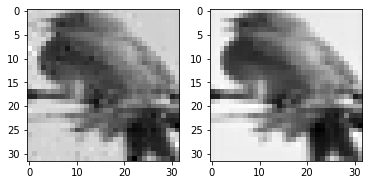

True label: 2
predicted label: 6
Time:  289.93627285957336  seconds
Generation 0
Max fitness value -0.4435219585111527
Generation 10
Max fitness value 0.9568292664627605
Generation 20
Max fitness value 0.9805844263939534
Generation 30
Max fitness value 0.9844253971124197
Generation 40
Max fitness value 0.9845210440821851
Generation 50
Max fitness value 0.9850095628490103
Generation 60
Max fitness value 0.9850647426165144
Generation 70
Max fitness value 0.9851650082806922
Generation 80
Max fitness value 0.9851650082806922
Generation 90
Max fitness value 0.9853748057684173
Generation 100
Max fitness value 0.9853748057684173
Generation 110
Max fitness value 0.9853948347322187
Generation 120
Max fitness value 0.9853948347322187
Generation 130
Max fitness value 0.9853948347322187
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


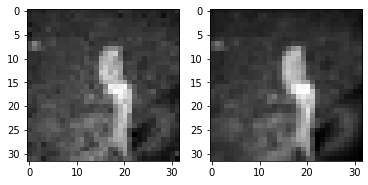

True label: 2
predicted label: 3
Time:  491.45589685440063  seconds
Generation 0
Max fitness value -0.46482523450026025
Generation 10
Max fitness value 0.8247582550985597
Generation 20
Max fitness value 0.9838901839314789
Generation 30
Max fitness value 0.9936588730771783
Generation 40
Max fitness value 0.9942889093340563
Generation 50
Max fitness value 0.9947444327547568
Generation 60
Max fitness value 0.9950417989415421
Generation 70
Max fitness value 0.9951175578108917
Generation 80
Max fitness value 0.9954553289397311
Generation 90
Max fitness value 0.9955612716248187
Generation 100
Max fitness value 0.9956731419448367
Generation 110
Max fitness value 0.995678223501604
Generation 120
Max fitness value 0.9957276373782313
Generation 130
Max fitness value 0.9957427243528014
Generation 140
Max fitness value 0.9958169808871453
Generation 150
Max fitness value 0.9958169808871453
Generation 160
Max fitness value 0.995894450324364
Generation 170
Max fitness value 0.9960212725214028
Generat

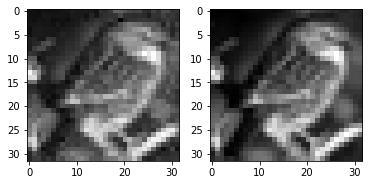

True label: 2
predicted label: 3
Time:  943.453362941742  seconds
Generation 0
Max fitness value 0.9654080272138503
Generation 10
Max fitness value 0.9969449328540775
Generation 20
Max fitness value 0.9974177437048065
Generation 30
Max fitness value 0.9975871112054668
Generation 40
Max fitness value 0.9975871112054668
Generation 50
Max fitness value 0.9975919072553352
Generation 60
Max fitness value 0.9975919072553352
Generation 70
Max fitness value 0.9975919072553352
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


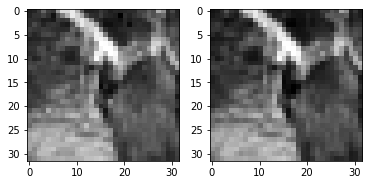

True label: 2
predicted label: 7
Time:  268.8020775318146  seconds
Generation 0
Max fitness value -0.6036426394415755
Generation 10
Max fitness value -0.6036426394415755
Generation 20
Max fitness value -0.6036426394415755
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


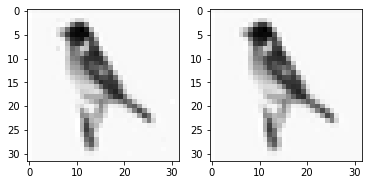

True label: 2
predicted label: 2
Time:  111.60589575767517  seconds
Generation 0
Max fitness value -0.6000051589632222
Generation 10
Max fitness value -0.6000051589632222
Generation 20
Max fitness value -0.6000051589632222
Generation 30
Max fitness value -0.5684951360393559
Generation 40
Max fitness value 0.735550004247616
Generation 50
Max fitness value 0.9893367990013151
Generation 60
Max fitness value 0.9894029515876328
Generation 70
Max fitness value 0.9901281607685919
Generation 80
Max fitness value 0.9906540649240256
Generation 90
Max fitness value 0.9910173555261708
Generation 100
Max fitness value 0.9914346646751826
Generation 110
Max fitness value 0.9915146996332757
Generation 120
Max fitness value 0.9916874788904584
Generation 130
Max fitness value 0.9916874788904584
Generation 140
Max fitness value 0.9917214038812596
Generation 150
Max fitness value 0.9917314327120639
Generation 160
Max fitness value 0.9918777576653355
Generation 170
Max fitness value 0.9918777576653355
Gene

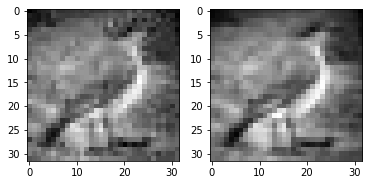

True label: 2
predicted label: 4
Time:  674.7331466674805  seconds
Generation 0
Max fitness value -0.6001222636522514
Generation 10
Max fitness value -0.6001222636522514
Generation 20
Max fitness value -0.058188950645082255
Generation 30
Max fitness value 0.8064202906397504
Generation 40
Max fitness value 0.9462180640534454
Generation 50
Max fitness value 0.9563075681408055
Generation 60
Max fitness value 0.9580184903628143
Generation 70
Max fitness value 0.9595553798147486
Generation 80
Max fitness value 0.9613103598226769
Generation 90
Max fitness value 0.9619304126903616
Generation 100
Max fitness value 0.9624568310428452
Generation 110
Max fitness value 0.9630188430116348
Generation 120
Max fitness value 0.9642914761911581
Generation 130
Max fitness value 0.9643876472014914
Generation 140
Max fitness value 0.9653273980360317
Generation 150
Max fitness value 0.9653273980360317
Generation 160
Max fitness value 0.965909902406737
Generation 170
Max fitness value 0.9664472501668654
Gene

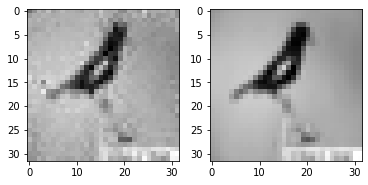

True label: 2
predicted label: 0
Time:  1168.2341840267181  seconds
Generation 0
Max fitness value 0.9977174862699818
Generation 10
Max fitness value 0.9988006540393883
Generation 20
Max fitness value 0.9988006540393883
Generation 30
Max fitness value 0.9988006540393883
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


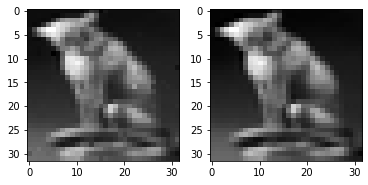

True label: 3
predicted label: 2
Time:  141.83307075500488  seconds
Generation 0
Max fitness value 0.6755424396710439
Generation 10
Max fitness value 0.9602309010174294
Generation 20
Max fitness value 0.987364353615414
Generation 30
Max fitness value 0.9881819003508203
Generation 40
Max fitness value 0.9881819003508203
Generation 50
Max fitness value 0.9881819003508203
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


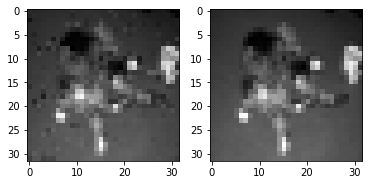

True label: 3
predicted label: 0
Time:  219.30482387542725  seconds
Generation 0
Max fitness value 0.03831771399141923
Generation 10
Max fitness value 0.9795362511797802
Generation 20
Max fitness value 0.9940911324773102
Generation 30
Max fitness value 0.9945051838875443
Generation 40
Max fitness value 0.9946038398033152
Generation 50
Max fitness value 0.9947174522649207
Generation 60
Max fitness value 0.9947594201239727
Generation 70
Max fitness value 0.9948361034380306
Generation 80
Max fitness value 0.9948463440760693
Generation 90
Max fitness value 0.9949311111457245
Generation 100
Max fitness value 0.9950737099383352
Generation 110
Max fitness value 0.9950737099383352
Generation 120
Max fitness value 0.9950948561581241
Generation 130
Max fitness value 0.9950948561581241
Generation 140
Max fitness value 0.9950948561581241
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


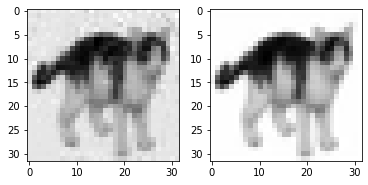

True label: 3
predicted label: 5
Time:  548.6483941078186  seconds
Generation 0
Max fitness value -0.4098354473441983
Generation 10
Max fitness value 0.7477525557808253
Generation 20
Max fitness value 0.9504263784428499
Generation 30
Max fitness value 0.9826362753976488
Generation 40
Max fitness value 0.9873707496665323
Generation 50
Max fitness value 0.9886337787751333
Generation 60
Max fitness value 0.9893946942884033
Generation 70
Max fitness value 0.9903922261729076
Generation 80
Max fitness value 0.9911795321208289
Generation 90
Max fitness value 0.9916102352717313
Generation 100
Max fitness value 0.9921052178567676
Generation 110
Max fitness value 0.9926427575122343
Generation 120
Max fitness value 0.9928277148898307
Generation 130
Max fitness value 0.9931191021613404
Generation 140
Max fitness value 0.9933491005490551
Generation 150
Max fitness value 0.9933949925823541
Generation 160
Max fitness value 0.9933949925823541
Generation 170
Max fitness value 0.99364529063389
Generatio

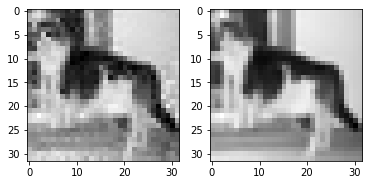

True label: 3
predicted label: 5
Time:  1467.1346216201782  seconds
Generation 0
Max fitness value 0.8700985299690471
Generation 10
Max fitness value 0.9965072106954314
Generation 20
Max fitness value 0.9977810945468886
Generation 30
Max fitness value 0.9980145515984102
Generation 40
Max fitness value 0.9980145515984102
Generation 50
Max fitness value 0.9980364363229389
Generation 60
Max fitness value 0.9980364363229389
Generation 70
Max fitness value 0.9980364363229389
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


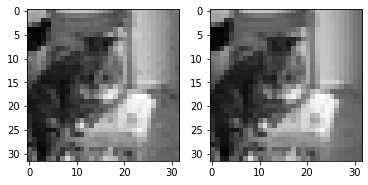

True label: 3
predicted label: 2
Time:  289.23350048065186  seconds
Generation 0
Max fitness value 0.057371075310577446
Generation 10
Max fitness value 0.9789361153984133
Generation 20
Max fitness value 0.9935228635586157
Generation 30
Max fitness value 0.9941601873835599
Generation 40
Max fitness value 0.9945258116599002
Generation 50
Max fitness value 0.994529414069002
Generation 60
Max fitness value 0.9946139406661114
Generation 70
Max fitness value 0.9946139406661114
Generation 80
Max fitness value 0.9946139406661114
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


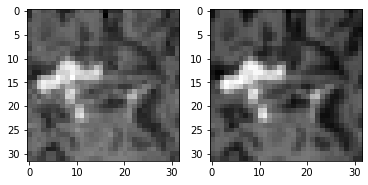

True label: 3
predicted label: 6
Time:  323.92561435699463  seconds
Generation 0
Max fitness value -0.5679503536564584
Generation 10
Max fitness value 0.5700167439630798
Generation 20
Max fitness value 0.9675452600178995
Generation 30
Max fitness value 0.9866778272228123
Generation 40
Max fitness value 0.989887254590009
Generation 50
Max fitness value 0.9907720322642083
Generation 60
Max fitness value 0.9912666625414559
Generation 70
Max fitness value 0.9913362520278692
Generation 80
Max fitness value 0.9913362520278692
Generation 90
Max fitness value 0.9915836324155914
Generation 100
Max fitness value 0.9918270376787279
Generation 110
Max fitness value 0.9922392697121736
Generation 120
Max fitness value 0.9922482399498972
Generation 130
Max fitness value 0.9923881186992443
Generation 140
Max fitness value 0.9926095895178544
Generation 150
Max fitness value 0.9926095895178544
Generation 160
Max fitness value 0.9927526795195303
Generation 170
Max fitness value 0.9927526795195303
Generat

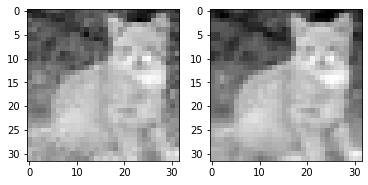

True label: 3
predicted label: 5
Time:  707.3643698692322  seconds
Generation 0
Max fitness value 0.4924043282702311
Generation 10
Max fitness value 0.9696807995906881
Generation 20
Max fitness value 0.9819799037076693
Generation 30
Max fitness value 0.9838918186177854
Generation 40
Max fitness value 0.9838918186177854
Generation 50
Max fitness value 0.984627027118276
Generation 60
Max fitness value 0.9850909378453738
Generation 70
Max fitness value 0.9850909378453738
Generation 80
Max fitness value 0.9850909378453738
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


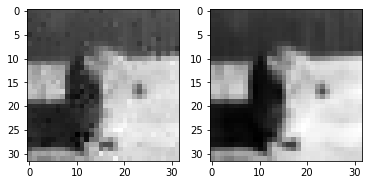

True label: 3
predicted label: 7
Time:  309.481486082077  seconds
Generation 0
Max fitness value -0.5115518392934998
Generation 10
Max fitness value 0.8740139724526373
Generation 20
Max fitness value 0.957899150555962
Generation 30
Max fitness value 0.9619361873383875
Generation 40
Max fitness value 0.963920944720218
Generation 50
Max fitness value 0.963920944720218
Generation 60
Max fitness value 0.9640690815346313
Generation 70
Max fitness value 0.9641177503302052
Generation 80
Max fitness value 0.965468299552293
Generation 90
Max fitness value 0.9667145405227822
Generation 100
Max fitness value 0.9673132029481742
Generation 110
Max fitness value 0.9679213900039105
Generation 120
Max fitness value 0.9689491019382608
Generation 130
Max fitness value 0.9689491019382608
Generation 140
Max fitness value 0.9693743165143427
Generation 150
Max fitness value 0.9693743165143427
Generation 160
Max fitness value 0.9693743165143427
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial imag

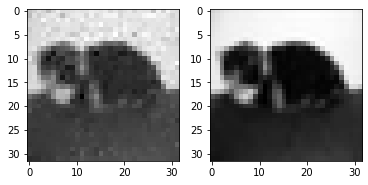

True label: 3
predicted label: 5
Time:  641.858470916748  seconds
Generation 0
Max fitness value -0.26660875587154187
Generation 10
Max fitness value 0.9698333580332095
Generation 20
Max fitness value 0.9951527506796973
Generation 30
Max fitness value 0.995837543202009
Generation 40
Max fitness value 0.9960541221255212
Generation 50
Max fitness value 0.9961619093182942
Generation 60
Max fitness value 0.9961619093182942
Generation 70
Max fitness value 0.996393460102519
Generation 80
Max fitness value 0.9964517140951109
Generation 90
Max fitness value 0.9965094251709864
Generation 100
Max fitness value 0.9965151682269159
Generation 110
Max fitness value 0.9965151682269159
Generation 120
Max fitness value 0.9965151682269159
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


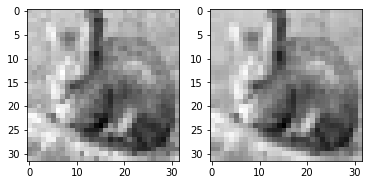

True label: 3
predicted label: 2
Time:  456.48281693458557  seconds
Generation 0
Max fitness value -0.4086436836435938
Generation 10
Max fitness value 0.8992417957505618
Generation 20
Max fitness value 0.9844299587631371
Generation 30
Max fitness value 0.9891292967638488
Generation 40
Max fitness value 0.9899480701164991
Generation 50
Max fitness value 0.9906930378438699
Generation 60
Max fitness value 0.9911199527920405
Generation 70
Max fitness value 0.9915106523160384
Generation 80
Max fitness value 0.9918238285882723
Generation 90
Max fitness value 0.9923772563865679
Generation 100
Max fitness value 0.9924561883598255
Generation 110
Max fitness value 0.9928547103972035
Generation 120
Max fitness value 0.9930157788778554
Generation 130
Max fitness value 0.9931799888758726
Generation 140
Max fitness value 0.9934268612381421
Generation 150
Max fitness value 0.9934389240423945
Generation 160
Max fitness value 0.9936692771554793
Generation 170
Max fitness value 0.9937184022000228
Genera

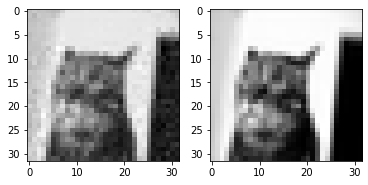

True label: 3
predicted label: 2
Time:  811.4330275058746  seconds
Generation 0
Max fitness value 0.8943222668916285
Generation 10
Max fitness value 0.9966646943610294
Generation 20
Max fitness value 0.9970675509937716
Generation 30
Max fitness value 0.9972966621574562
Generation 40
Max fitness value 0.9973276960885418
Generation 50
Max fitness value 0.9973743330350419
Generation 60
Max fitness value 0.997538966452596
Generation 70
Max fitness value 0.997538966452596
Generation 80
Max fitness value 0.997538966452596
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


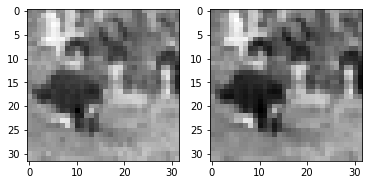

True label: 3
predicted label: 2
Time:  334.00829005241394  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.5529817431992778
Generation 0
Max fitness value 0.6588053909561818
Generation 10
Max fitness value 0.988666578058689
Generation 20
Max fitness value 0.9962320070329467
Generation 30
Max fitness value 0.9964468159030234
Generation 40
Max fitness value 0.9964468159030234
Generation 50
Max fitness value 0.9964468159030234
Generation 60
Max fitness value 0.9964845291605169
Generation 70
Max fitness value 0.996503907684094
Generation 80
Max fitness value 0.996503907684094
Generation 90
Max fitness value 0.996503907684094
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


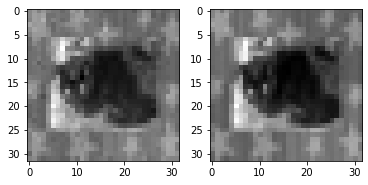

True label: 3
predicted label: 5
Time:  345.69703006744385  seconds
Generation 0
Max fitness value -0.5999934057400238
Generation 10
Max fitness value -0.5999934057400238
Generation 20
Max fitness value -0.5999934057400238
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


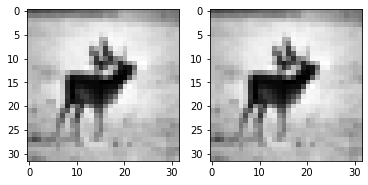

True label: 4
predicted label: 4
Time:  112.14648652076721  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.7673179154141161
Generation 0
Max fitness value 0.8596619422357097
Generation 10
Max fitness value 0.9969934471670223
Generation 20
Max fitness value 0.9975668201112788
Generation 30
Max fitness value 0.9978005592933009
Generation 40
Max fitness value 0.9978442993500167
Generation 50
Max fitness value 0.9979064885289433
Generation 60
Max fitness value 0.9979064885289433
Generation 70
Max fitness value 0.9979064885289433
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


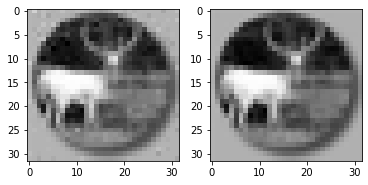

True label: 4
predicted label: 1
Time:  284.47041869163513  seconds
Generation 0
Max fitness value -0.18416566415159719
Generation 10
Max fitness value 0.9846131995804134
Generation 20
Max fitness value 0.9939069798518845
Generation 30
Max fitness value 0.9941011091255776
Generation 40
Max fitness value 0.9943444404879569
Generation 50
Max fitness value 0.9944839983720526
Generation 60
Max fitness value 0.9944839983720526
Generation 70
Max fitness value 0.9944839983720526
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


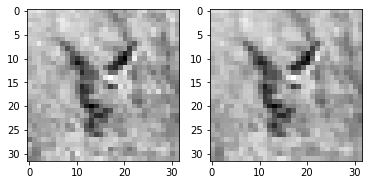

True label: 4
predicted label: 2
Time:  298.5430631637573  seconds
Generation 0
Max fitness value -0.5660349208268303
Generation 10
Max fitness value 0.8444480427582127
Generation 20
Max fitness value 0.986429739412334
Generation 30
Max fitness value 0.9953342983281392
Generation 40
Max fitness value 0.9956980122232628
Generation 50
Max fitness value 0.9959385835141641
Generation 60
Max fitness value 0.9959385835141641
Generation 70
Max fitness value 0.9959574009802263
Generation 80
Max fitness value 0.9962452767750821
Generation 90
Max fitness value 0.9962452767750821
Generation 100
Max fitness value 0.9962816245516724
Generation 110
Max fitness value 0.996326009853442
Generation 120
Max fitness value 0.9963731018628689
Generation 130
Max fitness value 0.9963731018628689
Generation 140
Max fitness value 0.9963731018628689
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


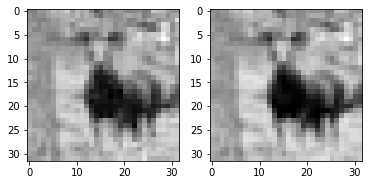

True label: 4
predicted label: 7
Time:  552.7662045955658  seconds
Generation 0
Max fitness value 0.21316791973253021
Generation 10
Max fitness value 0.9847110151453786
Generation 20
Max fitness value 0.9850855190987295
Generation 30
Max fitness value 0.9850855190987295
Generation 40
Max fitness value 0.9850855190987295
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


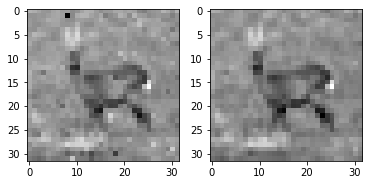

True label: 4
predicted label: 2
Time:  168.50849986076355  seconds
Generation 0
Max fitness value -0.5535284791883087
Generation 10
Max fitness value 0.9774328581173487
Generation 20
Max fitness value 0.9895812059186201
Generation 30
Max fitness value 0.9897868419634761
Generation 40
Max fitness value 0.9903061840907783
Generation 50
Max fitness value 0.9903061840907783
Generation 60
Max fitness value 0.9903061840907783
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


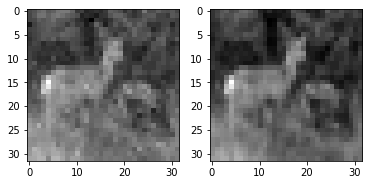

True label: 4
predicted label: 2
Time:  234.29921197891235  seconds
Generation 0
Max fitness value 0.7155875139189567
Generation 10
Max fitness value 0.9773744016616482
Generation 20
Max fitness value 0.9853292920224428
Generation 30
Max fitness value 0.9884971610913076
Generation 40
Max fitness value 0.9886282510658816
Generation 50
Max fitness value 0.9896636793646696
Generation 60
Max fitness value 0.9896636793646696
Generation 70
Max fitness value 0.9896636793646696
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


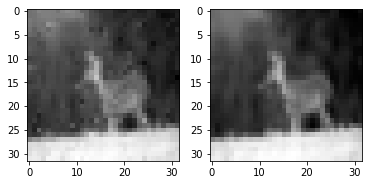

True label: 4
predicted label: 3
Time:  299.4019453525543  seconds
Generation 0
Max fitness value 0.9987901313881524
Generation 10
Max fitness value 0.9992480068260192
Generation 20
Max fitness value 0.9992480068260192
Generation 30
Max fitness value 0.9992480068260192
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


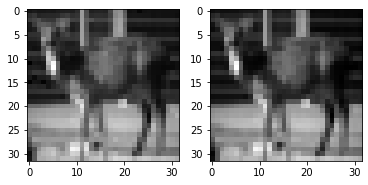

True label: 4
predicted label: 7
Time:  138.4571053981781  seconds
Generation 0
Max fitness value -0.5048442590011613
Generation 10
Max fitness value 0.8472974748494153
Generation 20
Max fitness value 0.9930136010490493
Generation 30
Max fitness value 0.9949873083111812
Generation 40
Max fitness value 0.9953416368408363
Generation 50
Max fitness value 0.9953416368408363
Generation 60
Max fitness value 0.9954825243493479
Generation 70
Max fitness value 0.9955700802634184
Generation 80
Max fitness value 0.9955700802634184
Generation 90
Max fitness value 0.9955700802634184
Generation 100
Max fitness value 0.9957688640783878
Generation 110
Max fitness value 0.9958860731763762
Generation 120
Max fitness value 0.9958860731763762
Generation 130
Max fitness value 0.9958860731763762
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


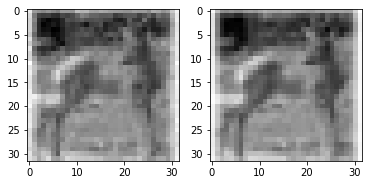

True label: 4
predicted label: 7
Time:  521.4865188598633  seconds
Generation 0
Max fitness value -0.5665275072219689
Generation 10
Max fitness value 0.9138045827128043
Generation 20
Max fitness value 0.9890464878460579
Generation 30
Max fitness value 0.9901692254866721
Generation 40
Max fitness value 0.9901692254866721
Generation 50
Max fitness value 0.9903819107545718
Generation 60
Max fitness value 0.9903895270165255
Generation 70
Max fitness value 0.9906875083856282
Generation 80
Max fitness value 0.9908703837040481
Generation 90
Max fitness value 0.9908778663076285
Generation 100
Max fitness value 0.9908778663076285
Generation 110
Max fitness value 0.9908778663076285
Generation 120
Max fitness value 0.9908778663076285
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


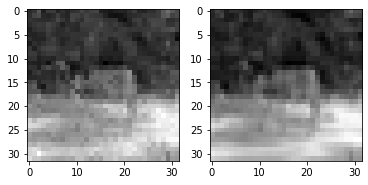

True label: 4
predicted label: 2
Time:  452.17503333091736  seconds
Generation 0
Max fitness value 0.4347996195966021
Generation 10
Max fitness value 0.9942873492430002
Generation 20
Max fitness value 0.9947877324408547
Generation 30
Max fitness value 0.9950660281571626
Generation 40
Max fitness value 0.9951992671820411
Generation 50
Max fitness value 0.9953971209005809
Generation 60
Max fitness value 0.9955817399451009
Generation 70
Max fitness value 0.9955817399451009
Generation 80
Max fitness value 0.9955817399451009
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


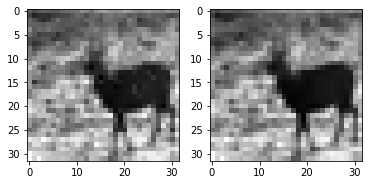

True label: 4
predicted label: 2
Time:  310.4310019016266  seconds
Generation 0
Max fitness value -0.5656949524870053
Generation 10
Max fitness value 0.8893283523439965
Generation 20
Max fitness value 0.9926959369219395
Generation 30
Max fitness value 0.9931319286204349
Generation 40
Max fitness value 0.9933922441288467
Generation 50
Max fitness value 0.9938782469658062
Generation 60
Max fitness value 0.993975724298756
Generation 70
Max fitness value 0.993975724298756
Generation 80
Max fitness value 0.993975724298756
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


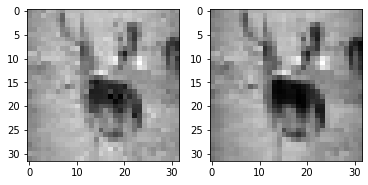

True label: 4
predicted label: 2
Time:  336.84813928604126  seconds
Generation 0
Max fitness value 0.6535326349090174
Generation 10
Max fitness value 0.9826242045515431
Generation 20
Max fitness value 0.9931493141801303
Generation 30
Max fitness value 0.9934923851057087
Generation 40
Max fitness value 0.9937893435143836
Generation 50
Max fitness value 0.9937893435143836
Generation 60
Max fitness value 0.9937893435143836
Generation 70
Max fitness value 0.9939421161822739
Generation 80
Max fitness value 0.9940760469223401
Generation 90
Max fitness value 0.9941745953111878
Generation 100
Max fitness value 0.9941745953111878
Generation 110
Max fitness value 0.9941745953111878
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


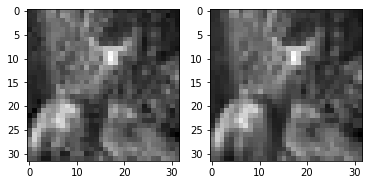

True label: 4
predicted label: 3
Time:  447.52951169013977  seconds
Generation 0
Max fitness value 0.38252348121066077
Generation 10
Max fitness value 0.9711982546138729
Generation 20
Max fitness value 0.9782067161959676
Generation 30
Max fitness value 0.979068875048384
Generation 40
Max fitness value 0.979068875048384
Generation 50
Max fitness value 0.979068875048384
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


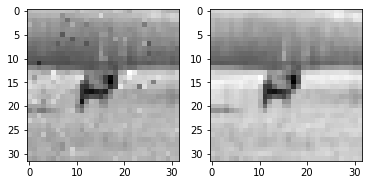

True label: 4
predicted label: 0
Time:  219.9777421951294  seconds
Generation 0
Max fitness value 0.7908225745652456
Generation 10
Max fitness value 0.9859784351888884
Generation 20
Max fitness value 0.9887688703826938
Generation 30
Max fitness value 0.9887688703826938
Generation 40
Max fitness value 0.9887688703826938
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


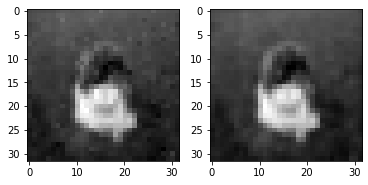

True label: 5
predicted label: 3
Time:  175.85801219940186  seconds
Generation 0
Max fitness value -0.5541818233859463
Generation 10
Max fitness value 0.7395233474841698
Generation 20
Max fitness value 0.9837576562488459
Generation 30
Max fitness value 0.9921402275974186
Generation 40
Max fitness value 0.9929219635635378
Generation 50
Max fitness value 0.9934756260988213
Generation 60
Max fitness value 0.9937669377257055
Generation 70
Max fitness value 0.9941651534002628
Generation 80
Max fitness value 0.9943716450173556
Generation 90
Max fitness value 0.9943888483218812
Generation 100
Max fitness value 0.9943888483218812
Generation 110
Max fitness value 0.9943888483218812
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


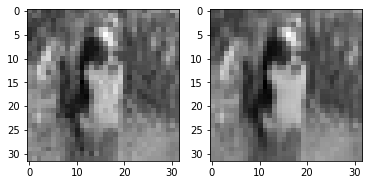

True label: 5
predicted label: 2
Time:  421.09646248817444  seconds
Generation 0
Max fitness value 0.3413675877515514
Generation 10
Max fitness value 0.9873550720913682
Generation 20
Max fitness value 0.990592187653684
Generation 30
Max fitness value 0.9910010543917747
Generation 40
Max fitness value 0.9913430536767833
Generation 50
Max fitness value 0.9915181786751022
Generation 60
Max fitness value 0.9917255276539274
Generation 70
Max fitness value 0.9917255276539274
Generation 80
Max fitness value 0.9917255276539274
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


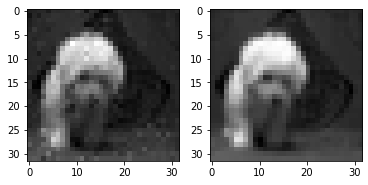

True label: 5
predicted label: 2
Time:  336.876104593277  seconds
Generation 0
Max fitness value -0.5318375585907753
Generation 10
Max fitness value 0.8739477815853935
Generation 20
Max fitness value 0.9802270171604752
Generation 30
Max fitness value 0.9884399944581921
Generation 40
Max fitness value 0.9906761670480754
Generation 50
Max fitness value 0.9911222875290462
Generation 60
Max fitness value 0.99153684425257
Generation 70
Max fitness value 0.991646589486066
Generation 80
Max fitness value 0.9919170249285401
Generation 90
Max fitness value 0.9922654515475641
Generation 100
Max fitness value 0.9923398738219564
Generation 110
Max fitness value 0.9925859447956122
Generation 120
Max fitness value 0.9926505689433476
Generation 130
Max fitness value 0.9928280154867661
Generation 140
Max fitness value 0.9929626032868875
Generation 150
Max fitness value 0.9930673260414582
Generation 160
Max fitness value 0.9932808577722962
Generation 170
Max fitness value 0.9934271635795506
Generation 

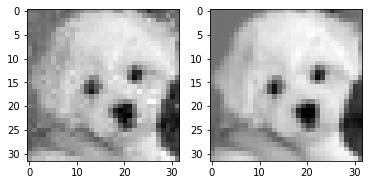

True label: 5
predicted label: 3
Time:  899.4698531627655  seconds
Generation 0
Max fitness value 0.7497099455912375
Generation 10
Max fitness value 0.9948466912099369
Generation 20
Max fitness value 0.9961076745533504
Generation 30
Max fitness value 0.996297263112793
Generation 40
Max fitness value 0.9964049908646374
Generation 50
Max fitness value 0.9964839230867757
Generation 60
Max fitness value 0.9964839230867757
Generation 70
Max fitness value 0.9964839230867757
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


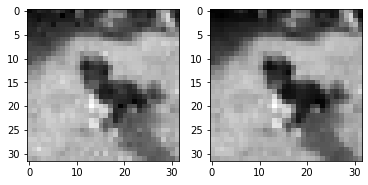

True label: 5
predicted label: 2
Time:  288.8655459880829  seconds
Generation 0
Max fitness value 0.5116432354475268
Generation 10
Max fitness value 0.9944384041294902
Generation 20
Max fitness value 0.9947267421987468
Generation 30
Max fitness value 0.9950121756352778
Generation 40
Max fitness value 0.9950403359391725
Generation 50
Max fitness value 0.9950403359391725
Generation 60
Max fitness value 0.9950403359391725
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


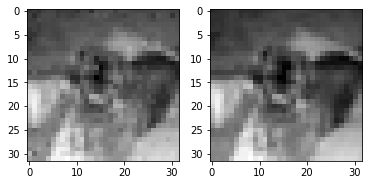

True label: 5
predicted label: 6
Time:  247.48005032539368  seconds
Generation 0
Max fitness value -0.5972781750205549
Generation 10
Max fitness value -0.32142750669076503
Generation 20
Max fitness value 0.9685846197767292
Generation 30
Max fitness value 0.9833970057575683
Generation 40
Max fitness value 0.9847529019893029
Generation 50
Max fitness value 0.9855815671248578
Generation 60
Max fitness value 0.9867355316990983
Generation 70
Max fitness value 0.9876036016827808
Generation 80
Max fitness value 0.9880585097758642
Generation 90
Max fitness value 0.988372423473628
Generation 100
Max fitness value 0.989096457473576
Generation 110
Max fitness value 0.989096457473576
Generation 120
Max fitness value 0.989096457473576
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


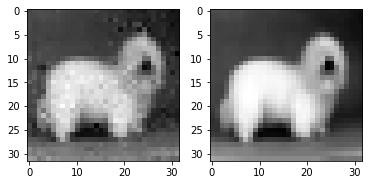

True label: 5
predicted label: 3
Time:  463.7445023059845  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.8074792014938936
Generation 0
Max fitness value 0.873105973171223
Generation 10
Max fitness value 0.9916656033151194
Generation 20
Max fitness value 0.9968973021853811
Generation 30
Max fitness value 0.997248852233912
Generation 40
Max fitness value 0.997425091419155
Generation 50
Max fitness value 0.9975210365544644
Generation 60
Max fitness value 0.9975563122767824
Generation 70
Max fitness value 0.9975563122767824
Generation 80
Max fitness value 0.9975563122767824
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


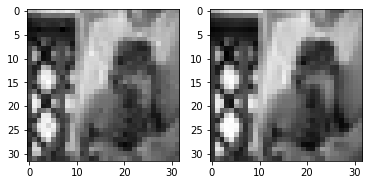

True label: 5
predicted label: 3
Time:  8776.401640415192  seconds
Generation 0
Max fitness value -0.16849587328240634
Generation 10
Max fitness value 0.8846863860103275
Generation 20
Max fitness value 0.9882048231047846
Generation 30
Max fitness value 0.9917702478207688
Generation 40
Max fitness value 0.992766693809605
Generation 50
Max fitness value 0.99302802446324
Generation 60
Max fitness value 0.9933405245783878
Generation 70
Max fitness value 0.9934891826442401
Generation 80
Max fitness value 0.9936116887358054
Generation 90
Max fitness value 0.9937859737329693
Generation 100
Max fitness value 0.9939576381549564
Generation 110
Max fitness value 0.9941881956921049
Generation 120
Max fitness value 0.9942311786755519
Generation 130
Max fitness value 0.9944504060007524
Generation 140
Max fitness value 0.9945863281171533
Generation 150
Max fitness value 0.9945863281171533
Generation 160
Max fitness value 0.9945905425694567
Generation 170
Max fitness value 0.994702541450035
Generation

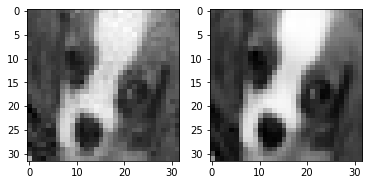

True label: 5
predicted label: 3
Time:  1007.5243806838989  seconds
Generation 0
Max fitness value 0.4722724922916922
Generation 10
Max fitness value 0.933912583774726
Generation 20
Max fitness value 0.9852812846471818
Generation 30
Max fitness value 0.9926657843239439
Generation 40
Max fitness value 0.9940563636892437
Generation 50
Max fitness value 0.994890497780198
Generation 60
Max fitness value 0.9951915797814869
Generation 70
Max fitness value 0.9952372183467875
Generation 80
Max fitness value 0.9953635614050402
Generation 90
Max fitness value 0.9956092235781635
Generation 100
Max fitness value 0.9956520298538272
Generation 110
Max fitness value 0.9956520298538272
Generation 120
Max fitness value 0.9958161747310972
Generation 130
Max fitness value 0.9958161747310972
Generation 140
Max fitness value 0.9958161747310972
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


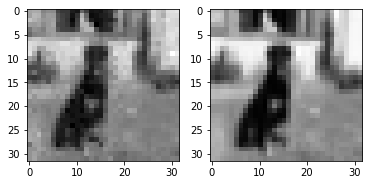

True label: 5
predicted label: 3
Time:  761.0026032924652  seconds
Generation 0
Max fitness value 0.7537098038514202
Generation 10
Max fitness value 0.9877064982294816
Generation 20
Max fitness value 0.9954403572463377
Generation 30
Max fitness value 0.9966610611262144
Generation 40
Max fitness value 0.9968025482090408
Generation 50
Max fitness value 0.9970026486698524
Generation 60
Max fitness value 0.9971146199813268
Generation 70
Max fitness value 0.9973119458991253
Generation 80
Max fitness value 0.9973364057617274
Generation 90
Max fitness value 0.9974496501563963
Generation 100
Max fitness value 0.9974878230796154
Generation 110
Max fitness value 0.9974878230796154
Generation 120
Max fitness value 0.9974878230796154
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


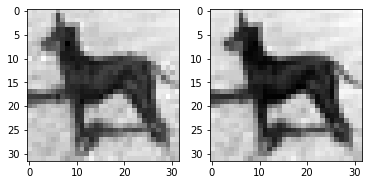

True label: 5
predicted label: 7
Time:  514.8713712692261  seconds
Generation 0
Max fitness value -0.5999994929040275
Generation 10
Max fitness value -0.5999994929040275
Generation 20
Max fitness value -0.3520039672454368
Generation 30
Max fitness value 0.9880845350173031
Generation 40
Max fitness value 0.9919678464284502
Generation 50
Max fitness value 0.9933022892559666
Generation 60
Max fitness value 0.9939135801069563
Generation 70
Max fitness value 0.9943622049725103
Generation 80
Max fitness value 0.9946925064390029
Generation 90
Max fitness value 0.9949554294685341
Generation 100
Max fitness value 0.9950469605283468
Generation 110
Max fitness value 0.995157700901792
Generation 120
Max fitness value 0.9952560887233771
Generation 130
Max fitness value 0.9952606075456705
Generation 140
Max fitness value 0.9953788380574801
Generation 150
Max fitness value 0.995557219874162
Generation 160
Max fitness value 0.995557219874162
Generation 170
Max fitness value 0.995557219874162
Generatio

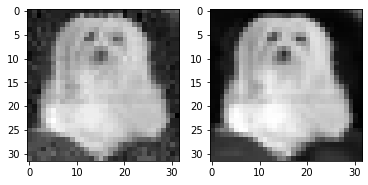

True label: 5
predicted label: 3
Time:  1077.4132945537567  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.5026331664006221
Generation 0
Max fitness value 0.5722254194305106
Generation 10
Max fitness value 0.9735254122871558
Generation 20
Max fitness value 0.9934407602245805
Generation 30
Max fitness value 0.9952724726339127
Generation 40
Max fitness value 0.9962201709017177
Generation 50
Max fitness value 0.9968680246756976
Generation 60
Max fitness value 0.99697938110655
Generation 70
Max fitness value 0.9971039326378222
Generation 80
Max fitness value 0.997205354845046
Generation 90
Max fitness value 0.9972794380996385
Generation 100
Max fitness value 0.9973309480005852
Generation 110
Max fitness value 0.9973881730202138
Generation 120
Max fitness value 0.9973985450330437
Generation 130
Max fitness value 0.9973985450330437
Generation 140
Max fitness value 0.9973985450330437
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	

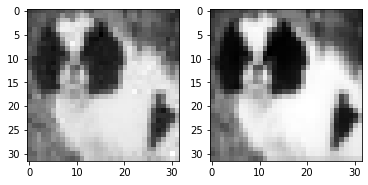

True label: 5
predicted label: 3
Time:  778.4206261634827  seconds
Generation 0
Max fitness value 0.9396172284579876
Generation 10
Max fitness value 0.9915649208553086
Generation 20
Max fitness value 0.9923831922676515
Generation 30
Max fitness value 0.9931219156166092
Generation 40
Max fitness value 0.9931219156166092
Generation 50
Max fitness value 0.9931219156166092
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


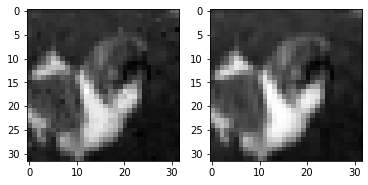

True label: 5
predicted label: 3
Time:  326.65636563301086  seconds
Generation 0
Max fitness value -0.6000327010935605
Generation 10
Max fitness value -0.6000327010935605
Generation 20
Max fitness value -0.6000327010935605
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


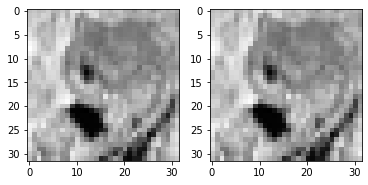

True label: 6
predicted label: 6
Time:  166.50295519828796  seconds
Generation 0
Max fitness value -0.347868585833723
Generation 10
Max fitness value 0.9668785612044067
Generation 20
Max fitness value 0.9958268066180664
Generation 30
Max fitness value 0.9960180990322502
Generation 40
Max fitness value 0.9960207246660675
Generation 50
Max fitness value 0.9960207246660675
Generation 60
Max fitness value 0.9960207246660675
Generation 70
Max fitness value 0.9961276533653379
Generation 80
Max fitness value 0.9962362037885166
Generation 90
Max fitness value 0.9962362037885166
Generation 100
Max fitness value 0.9962362037885166
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


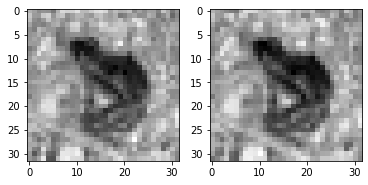

True label: 6
predicted label: 2
Time:  579.4847321510315  seconds
Generation 0
Max fitness value 0.7267807913474016
Generation 10
Max fitness value 0.9812503367463482
Generation 20
Max fitness value 0.9870631549937883
Generation 30
Max fitness value 0.9877509084737948
Generation 40
Max fitness value 0.9878209041732637
Generation 50
Max fitness value 0.9878209041732637
Generation 60
Max fitness value 0.9878209041732637
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


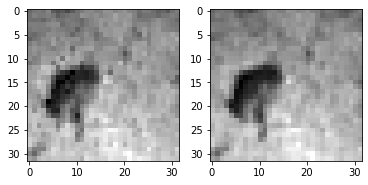

True label: 6
predicted label: 4
Time:  346.92593455314636  seconds
Generation 0
Max fitness value -0.5983173566211138
Generation 10
Max fitness value -0.15186044357487355
Generation 20
Max fitness value 0.9658778507516549
Generation 30
Max fitness value 0.9930771586930028
Generation 40
Max fitness value 0.9943230934076545
Generation 50
Max fitness value 0.9944434994733474
Generation 60
Max fitness value 0.995051888931811
Generation 70
Max fitness value 0.9951553827631012
Generation 80
Max fitness value 0.9955077731889661
Generation 90
Max fitness value 0.9956155856538321
Generation 100
Max fitness value 0.9957429330547097
Generation 110
Max fitness value 0.9958204460321418
Generation 120
Max fitness value 0.9958743144555307
Generation 130
Max fitness value 0.9959174926102432
Generation 140
Max fitness value 0.9960196617692535
Generation 150
Max fitness value 0.9960659202962877
Generation 160
Max fitness value 0.9960659202962877
Generation 170
Max fitness value 0.9960659202962877
FITNE

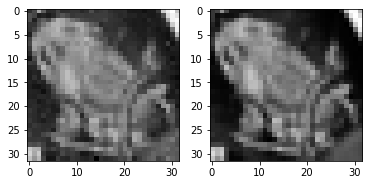

True label: 6
predicted label: 2
Time:  971.4160056114197  seconds
Generation 0
Max fitness value -0.5819222410591348
Generation 10
Max fitness value 0.8317679494366359
Generation 20
Max fitness value 0.9766099077211206
Generation 30
Max fitness value 0.9772510937447284
Generation 40
Max fitness value 0.9774719624273805
Generation 50
Max fitness value 0.9776274330525037
Generation 60
Max fitness value 0.9776274330525037
Generation 70
Max fitness value 0.9776274330525037
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


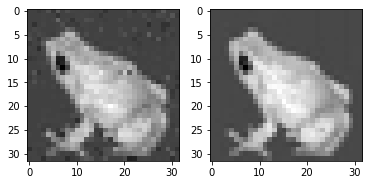

True label: 6
predicted label: 2
Time:  400.86580896377563  seconds
Generation 0
Max fitness value -0.22240698621758803
Generation 10
Max fitness value 0.9747448326590626
Generation 20
Max fitness value 0.9930018887603912
Generation 30
Max fitness value 0.9936778252956421
Generation 40
Max fitness value 0.9939238473463118
Generation 50
Max fitness value 0.9940009871726028
Generation 60
Max fitness value 0.9943343975052822
Generation 70
Max fitness value 0.9943343975052822
Generation 80
Max fitness value 0.9944125203086874
Generation 90
Max fitness value 0.9945885764589364
Generation 100
Max fitness value 0.9945885764589364
Generation 110
Max fitness value 0.9945885764589364
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


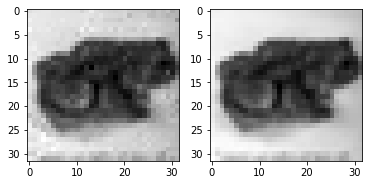

True label: 6
predicted label: 3
Time:  620.0734949111938  seconds
Generation 0
Max fitness value -0.5952064231164309
Generation 10
Max fitness value 0.5768446149086421
Generation 20
Max fitness value 0.9827814673755426
Generation 30
Max fitness value 0.9882082752625203
Generation 40
Max fitness value 0.9891361756261314
Generation 50
Max fitness value 0.9896808547540773
Generation 60
Max fitness value 0.9902049029890477
Generation 70
Max fitness value 0.991015634867116
Generation 80
Max fitness value 0.9911173090943032
Generation 90
Max fitness value 0.991268698026854
Generation 100
Max fitness value 0.991268698026854
Generation 110
Max fitness value 0.9914034745982613
Generation 120
Max fitness value 0.9914034745982613
Generation 130
Max fitness value 0.9915699823869435
Generation 140
Max fitness value 0.9916115090523758
Generation 150
Max fitness value 0.9917814123716161
Generation 160
Max fitness value 0.9917955928738096
Generation 170
Max fitness value 0.9917955928738096
Generation

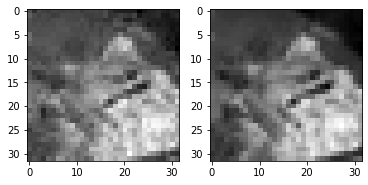

True label: 6
predicted label: 2
Time:  1503.2721214294434  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.3750367017033567
Generation 0
Max fitness value 0.649340703996884
Generation 10
Max fitness value 0.9936798728348928
Generation 20
Max fitness value 0.996560086682194
Generation 30
Max fitness value 0.9966987628273316
Generation 40
Max fitness value 0.9967946180903865
Generation 50
Max fitness value 0.9968747983893284
Generation 60
Max fitness value 0.9968747983893284
Generation 70
Max fitness value 0.9968747983893284
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


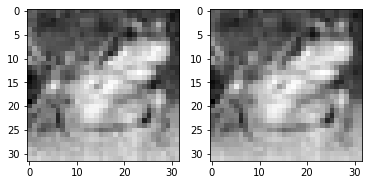

True label: 6
predicted label: 4
Time:  390.9282920360565  seconds
Generation 0
Max fitness value -0.599462585437788
Generation 10
Max fitness value -0.33531291809153535
Generation 20
Max fitness value 0.9650707748147185
Generation 30
Max fitness value 0.9909203656582477
Generation 40
Max fitness value 0.9921969772014634
Generation 50
Max fitness value 0.9927649193237804
Generation 60
Max fitness value 0.9929830099095849
Generation 70
Max fitness value 0.9934196303594711
Generation 80
Max fitness value 0.9936732351156649
Generation 90
Max fitness value 0.9937838542808258
Generation 100
Max fitness value 0.9937838542808258
Generation 110
Max fitness value 0.9939125178284586
Generation 120
Max fitness value 0.9939830680426728
Generation 130
Max fitness value 0.9939830680426728
Generation 140
Max fitness value 0.9940829825101714
Generation 150
Max fitness value 0.9940829825101714
Generation 160
Max fitness value 0.9940829825101714
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversaria

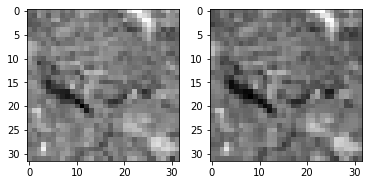

True label: 6
predicted label: 2
Time:  894.7369341850281  seconds
Generation 0
Max fitness value -0.524495568082136
Generation 10
Max fitness value 0.8160549651329745
Generation 20
Max fitness value 0.9867636776450083
Generation 30
Max fitness value 0.9912609229040178
Generation 40
Max fitness value 0.9914966058905909
Generation 50
Max fitness value 0.9919465794646066
Generation 60
Max fitness value 0.9922841231398394
Generation 70
Max fitness value 0.9924243258159142
Generation 80
Max fitness value 0.9927467105337154
Generation 90
Max fitness value 0.9929710948312176
Generation 100
Max fitness value 0.9930468617236381
Generation 110
Max fitness value 0.993097049067826
Generation 120
Max fitness value 0.993097049067826
Generation 130
Max fitness value 0.9931099193260529
Generation 140
Max fitness value 0.9932707141905202
Generation 150
Max fitness value 0.9932718078131875
Generation 160
Max fitness value 0.9932718078131875
Generation 170
Max fitness value 0.9932718078131875
FITNESS DI

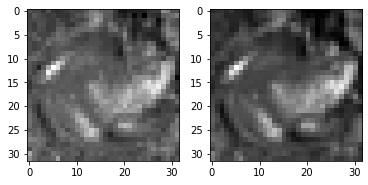

True label: 6
predicted label: 3
Time:  908.1066861152649  seconds
Generation 0
Max fitness value -0.595304205241812
Generation 10
Max fitness value 0.18860671067137263
Generation 20
Max fitness value 0.9799118786336073
Generation 30
Max fitness value 0.9931352792490276
Generation 40
Max fitness value 0.99374874609995
Generation 50
Max fitness value 0.9940795947627016
Generation 60
Max fitness value 0.9942448394057616
Generation 70
Max fitness value 0.9943120492050724
Generation 80
Max fitness value 0.9943616708722416
Generation 90
Max fitness value 0.9945161615520038
Generation 100
Max fitness value 0.994624447794228
Generation 110
Max fitness value 0.9949918918880658
Generation 120
Max fitness value 0.9949918918880658
Generation 130
Max fitness value 0.9951022270981674
Generation 140
Max fitness value 0.995171128130629
Generation 150
Max fitness value 0.9952060005757214
Generation 160
Max fitness value 0.9952366317120488
Generation 170
Max fitness value 0.9952391522818306
Generation 

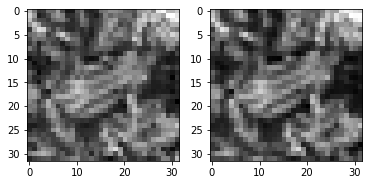

True label: 6
predicted label: 2
Time:  819.6366951465607  seconds
Generation 0
Max fitness value -0.5830971352646864
Generation 10
Max fitness value 0.7285163174067223
Generation 20
Max fitness value 0.9899916931941497
Generation 30
Max fitness value 0.9927142524762612
Generation 40
Max fitness value 0.9932036484419191
Generation 50
Max fitness value 0.9935300958704264
Generation 60
Max fitness value 0.9936364050124168
Generation 70
Max fitness value 0.9937249565520889
Generation 80
Max fitness value 0.9937809436961471
Generation 90
Max fitness value 0.9938420318564227
Generation 100
Max fitness value 0.9938420318564227
Generation 110
Max fitness value 0.9938420318564227
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


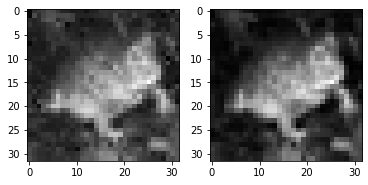

True label: 6
predicted label: 2
Time:  431.33979654312134  seconds
Generation 0
Max fitness value -0.5965256851088143
Generation 10
Max fitness value 0.20760093369335772
Generation 20
Max fitness value 0.9762123957071882
Generation 30
Max fitness value 0.9937378928610073
Generation 40
Max fitness value 0.9943655513803603
Generation 50
Max fitness value 0.9944712001315792
Generation 60
Max fitness value 0.9945982180826795
Generation 70
Max fitness value 0.9948429862313639
Generation 80
Max fitness value 0.9949498790206882
Generation 90
Max fitness value 0.9951191666812825
Generation 100
Max fitness value 0.9952073572168985
Generation 110
Max fitness value 0.9953724672731541
Generation 120
Max fitness value 0.9953724672731541
Generation 130
Max fitness value 0.9953724672731541
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


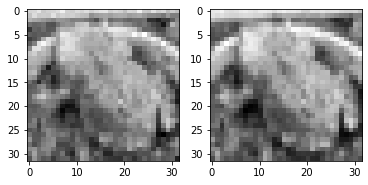

True label: 6
predicted label: 2
Time:  519.6873106956482  seconds
Generation 0
Max fitness value -0.5970149707845263
Generation 10
Max fitness value 0.8933813624658067
Generation 20
Max fitness value 0.9875157665972173
Generation 30
Max fitness value 0.9902627848853954
Generation 40
Max fitness value 0.9909227559279157
Generation 50
Max fitness value 0.9911554563605377
Generation 60
Max fitness value 0.991313653466238
Generation 70
Max fitness value 0.9913624864995941
Generation 80
Max fitness value 0.9913624864995941
Generation 90
Max fitness value 0.991504864916968
Generation 100
Max fitness value 0.991504864916968
Generation 110
Max fitness value 0.9915619263734491
Generation 120
Max fitness value 0.9916082198295988
Generation 130
Max fitness value 0.991706687783758
Generation 140
Max fitness value 0.991706687783758
Generation 150
Max fitness value 0.991706687783758
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground 

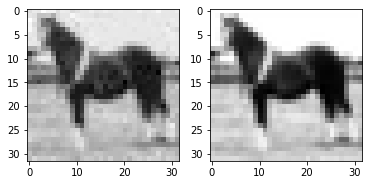

True label: 7
predicted label: 5
Time:  593.8686830997467  seconds
Generation 0
Max fitness value -0.5936151408088398
Generation 10
Max fitness value 0.9681328575516993
Generation 20
Max fitness value 0.9799844779966965
Generation 30
Max fitness value 0.9803981356126785
Generation 40
Max fitness value 0.981496476754149
Generation 50
Max fitness value 0.981496476754149
Generation 60
Max fitness value 0.981496476754149
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


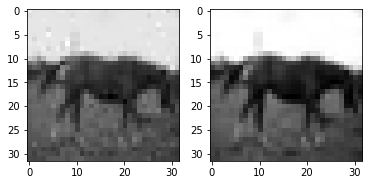

True label: 7
predicted label: 4
Time:  253.50512409210205  seconds
Generation 0
Max fitness value -0.59944586217024
Generation 10
Max fitness value -0.2547017619393702
Generation 20
Max fitness value 0.9515512090536871
Generation 30
Max fitness value 0.983344132408895
Generation 40
Max fitness value 0.9868668505686157
Generation 50
Max fitness value 0.9877310608010282
Generation 60
Max fitness value 0.988371039647452
Generation 70
Max fitness value 0.9893628896230479
Generation 80
Max fitness value 0.9893858176192069
Generation 90
Max fitness value 0.9898581573465712
Generation 100
Max fitness value 0.9901499254958824
Generation 110
Max fitness value 0.9901971685285345
Generation 120
Max fitness value 0.990679026443277
Generation 130
Max fitness value 0.9907642493820493
Generation 140
Max fitness value 0.9909364304766277
Generation 150
Max fitness value 0.9911407569280888
Generation 160
Max fitness value 0.9911407569280888
Generation 170
Max fitness value 0.9913626981823048
Generation

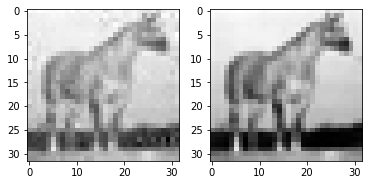

True label: 7
predicted label: 3
Time:  868.2224380970001  seconds
Generation 0
Max fitness value -0.28933901071189494
Generation 10
Max fitness value 0.96956142140173
Generation 20
Max fitness value 0.9935503295858077
Generation 30
Max fitness value 0.9937644978881925
Generation 40
Max fitness value 0.9940077461089405
Generation 50
Max fitness value 0.994445015602466
Generation 60
Max fitness value 0.994445015602466
Generation 70
Max fitness value 0.9947783801564639
Generation 80
Max fitness value 0.9948564197593941
Generation 90
Max fitness value 0.9949165369010232
Generation 100
Max fitness value 0.9949165369010232
Generation 110
Max fitness value 0.9949165369010232
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


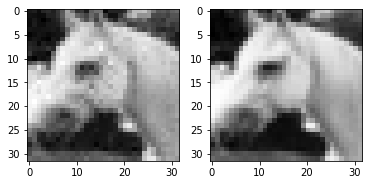

True label: 7
predicted label: 3
Time:  638.5178561210632  seconds
Generation 0
Max fitness value -0.119097424615035
Generation 10
Max fitness value 0.9782030895954211
Generation 20
Max fitness value 0.983523061890514
Generation 30
Max fitness value 0.9845038907003156
Generation 40
Max fitness value 0.9851878665312792
Generation 50
Max fitness value 0.9862720044549214
Generation 60
Max fitness value 0.9863009058922048
Generation 70
Max fitness value 0.9864451868482191
Generation 80
Max fitness value 0.9866495993165789
Generation 90
Max fitness value 0.9871989253225388
Generation 100
Max fitness value 0.9871989253225388
Generation 110
Max fitness value 0.9872982217753175
Generation 120
Max fitness value 0.9874593806735772
Generation 130
Max fitness value 0.9874593806735772
Generation 140
Max fitness value 0.9874593806735772
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


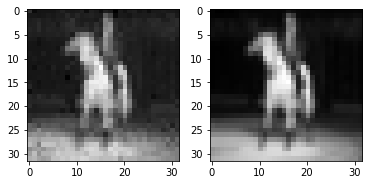

True label: 7
predicted label: 5
Time:  761.0569694042206  seconds
Generation 0
Max fitness value -0.5999890779035426
Generation 10
Max fitness value -0.06897703898338017
Generation 20
Max fitness value 0.9559734640193567
Generation 30
Max fitness value 0.9839362001569718
Generation 40
Max fitness value 0.9861785912669733
Generation 50
Max fitness value 0.987023865590696
Generation 60
Max fitness value 0.9877068295824367
Generation 70
Max fitness value 0.9877361409153602
Generation 80
Max fitness value 0.9880326781377676
Generation 90
Max fitness value 0.9880879146652637
Generation 100
Max fitness value 0.9881443491252518
Generation 110
Max fitness value 0.9882699914493894
Generation 120
Max fitness value 0.9882699914493894
Generation 130
Max fitness value 0.9882993545583305
Generation 140
Max fitness value 0.9882993545583305
Generation 150
Max fitness value 0.9882993545583305
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: 

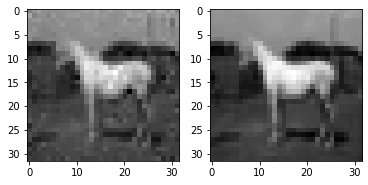

True label: 7
predicted label: 5
Time:  817.3267993927002  seconds
Generation 0
Max fitness value 0.7573057317114503
Generation 10
Max fitness value 0.9931973463415713
Generation 20
Max fitness value 0.994198476184326
Generation 30
Max fitness value 0.9944019396994348
Generation 40
Max fitness value 0.9948280878684274
Generation 50
Max fitness value 0.9949272316590483
Generation 60
Max fitness value 0.9949272316590483
Generation 70
Max fitness value 0.9949272316590483
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


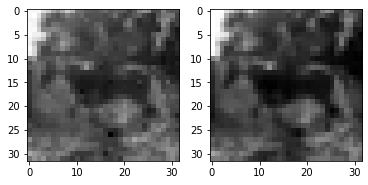

True label: 7
predicted label: 2
Time:  408.90558767318726  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.5198460432169061
FOUND ADVERSARIAL
Fitness of the adversarial 0.6693733167518654
Adversarial example image: 

Left: adversarial 	 Right: ground truth


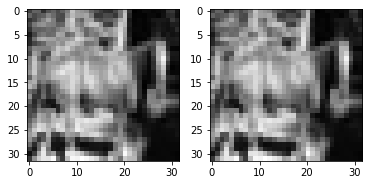

True label: 7
predicted label: 9
Time:  6.581073999404907  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.5577562365963048
Generation 0
Max fitness value 0.685036179759932
Generation 10
Max fitness value 0.9975280623925901
Generation 20
Max fitness value 0.998079235897056
Generation 30
Max fitness value 0.9982752315550474
Generation 40
Max fitness value 0.9983058056122779
Generation 50
Max fitness value 0.9983469637034601
Generation 60
Max fitness value 0.9983483873859537
Generation 70
Max fitness value 0.9983483873859537
Generation 80
Max fitness value 0.9983483873859537
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


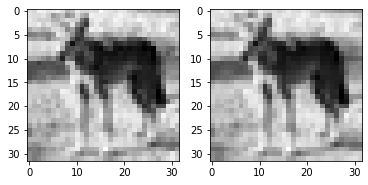

True label: 7
predicted label: 4
Time:  371.7043995857239  seconds
Generation 0
Max fitness value -0.47437979276571685
Generation 10
Max fitness value 0.9839626465823127
Generation 20
Max fitness value 0.9961894889355682
Generation 30
Max fitness value 0.9966192518859112
Generation 40
Max fitness value 0.9966192518859112
Generation 50
Max fitness value 0.9968098318097885
Generation 60
Max fitness value 0.9968732321515383
Generation 70
Max fitness value 0.9970534995342524
Generation 80
Max fitness value 0.9971355152224738
Generation 90
Max fitness value 0.9971506318716584
Generation 100
Max fitness value 0.997237661480103
Generation 110
Max fitness value 0.9972682781749611
Generation 120
Max fitness value 0.9972682781749611
Generation 130
Max fitness value 0.9972682781749611
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


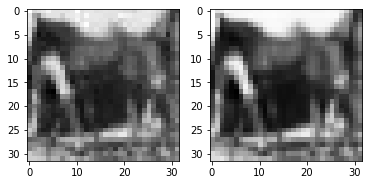

True label: 7
predicted label: 6
Time:  596.2723240852356  seconds
Generation 0
Max fitness value -0.5891373097067142
Generation 10
Max fitness value 0.9595694776151639
Generation 20
Max fitness value 0.9938010090992075
Generation 30
Max fitness value 0.9957349982453881
Generation 40
Max fitness value 0.9957682352325935
Generation 50
Max fitness value 0.995882523071471
Generation 60
Max fitness value 0.9960091969063269
Generation 70
Max fitness value 0.9961242562100285
Generation 80
Max fitness value 0.99619637576355
Generation 90
Max fitness value 0.99619637576355
Generation 100
Max fitness value 0.99619637576355
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


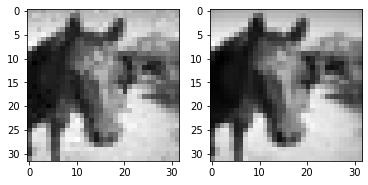

True label: 7
predicted label: 3
Time:  404.1503813266754  seconds
Generation 0
Max fitness value -0.535057294902128
Generation 10
Max fitness value 0.9789968154486033
Generation 20
Max fitness value 0.9943721786577349
Generation 30
Max fitness value 0.9949853448707304
Generation 40
Max fitness value 0.9954134218002265
Generation 50
Max fitness value 0.9955954636874345
Generation 60
Max fitness value 0.9958149601988739
Generation 70
Max fitness value 0.9958149601988739
Generation 80
Max fitness value 0.9958961732279104
Generation 90
Max fitness value 0.995931843526602
Generation 100
Max fitness value 0.995931843526602
Generation 110
Max fitness value 0.995931843526602
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


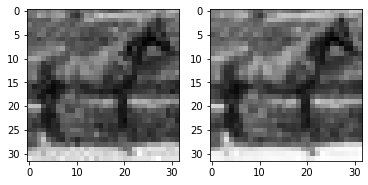

True label: 7
predicted label: 4
Time:  432.20444917678833  seconds
Generation 0
Max fitness value 0.12219254832959343
Generation 10
Max fitness value 0.946260631087031
Generation 20
Max fitness value 0.9908498553413567
Generation 30
Max fitness value 0.9924112700649659
Generation 40
Max fitness value 0.9930953602835023
Generation 50
Max fitness value 0.9934297305898278
Generation 60
Max fitness value 0.9939055605284525
Generation 70
Max fitness value 0.9939055605284525
Generation 80
Max fitness value 0.9939055605284525
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


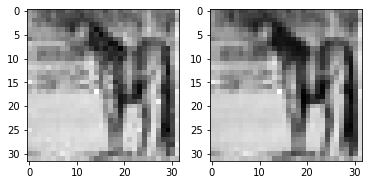

True label: 7
predicted label: 4
Time:  343.80611181259155  seconds
Generation 0
Max fitness value -0.5977446626221228
Generation 10
Max fitness value 0.24050842848088663
Generation 20
Max fitness value 0.9680916367897887
Generation 30
Max fitness value 0.9882231413616627
Generation 40
Max fitness value 0.9905159090229455
Generation 50
Max fitness value 0.9919524486620844
Generation 60
Max fitness value 0.9923156905613609
Generation 70
Max fitness value 0.9924327239869332
Generation 80
Max fitness value 0.9929498305998332
Generation 90
Max fitness value 0.9930935616741304
Generation 100
Max fitness value 0.9933225607763808
Generation 110
Max fitness value 0.9933225607763808
Generation 120
Max fitness value 0.9933876812970129
Generation 130
Max fitness value 0.9933876812970129
Generation 140
Max fitness value 0.9934344109583393
Generation 150
Max fitness value 0.9934344109583393
Generation 160
Max fitness value 0.9934344109583393
Generation 170
Max fitness value 0.9934501117140992
Gener

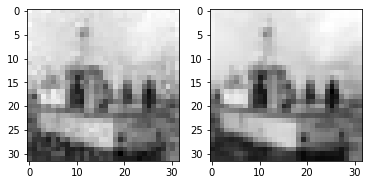

True label: 8
predicted label: 9
Time:  825.3450055122375  seconds
Generation 0
Max fitness value -0.4050069497743482
Generation 10
Max fitness value 0.9797581947228735
Generation 20
Max fitness value 0.9910459386829776
Generation 30
Max fitness value 0.9914914769576584
Generation 40
Max fitness value 0.9929385251979619
Generation 50
Max fitness value 0.9931534132719775
Generation 60
Max fitness value 0.9932560457824146
Generation 70
Max fitness value 0.9932560457824146
Generation 80
Max fitness value 0.9932560457824146
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


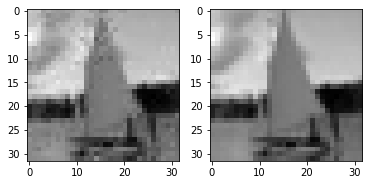

True label: 8
predicted label: 4
Time:  316.64242029190063  seconds
Generation 0
Max fitness value 0.38010234359740075
Generation 10
Max fitness value 0.9922958931471866
Generation 20
Max fitness value 0.9927906957719403
Generation 30
Max fitness value 0.9933294232921145
Generation 40
Max fitness value 0.9933294232921145
Generation 50
Max fitness value 0.9933294232921145
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


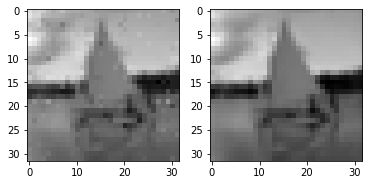

True label: 8
predicted label: 0
Time:  221.68131041526794  seconds
Generation 0
Max fitness value -0.5998782388075192
Generation 10
Max fitness value -0.5998782388075192
Generation 20
Max fitness value 0.0985651234366074
Generation 30
Max fitness value 0.9393699819233992
Generation 40
Max fitness value 0.9596013870647855
Generation 50
Max fitness value 0.9613103336350425
Generation 60
Max fitness value 0.9642262010300985
Generation 70
Max fitness value 0.9658380539528516
Generation 80
Max fitness value 0.9680243623896808
Generation 90
Max fitness value 0.9692051471248078
Generation 100
Max fitness value 0.9706000949826145
Generation 110
Max fitness value 0.9715523074615924
Generation 120
Max fitness value 0.9719873035761399
Generation 130
Max fitness value 0.9719873035761399
Generation 140
Max fitness value 0.9719873035761399
Generation 150
Max fitness value 0.972333580600467
Generation 160
Max fitness value 0.9723337008021455
Generation 170
Max fitness value 0.9725099818648498
Genera

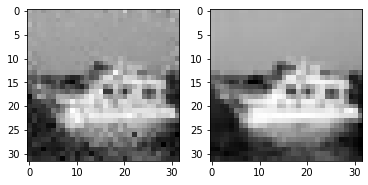

True label: 8
predicted label: 0
Time:  920.6236057281494  seconds
Generation 0
Max fitness value -0.5988952042069703
Generation 10
Max fitness value 0.8444772369184588
Generation 20
Max fitness value 0.9956908310602837
Generation 30
Max fitness value 0.9966110581371825
Generation 40
Max fitness value 0.9968775046942069
Generation 50
Max fitness value 0.9970176902971932
Generation 60
Max fitness value 0.9971817967798405
Generation 70
Max fitness value 0.9972427012891933
Generation 80
Max fitness value 0.997301875581329
Generation 90
Max fitness value 0.9973373298228433
Generation 100
Max fitness value 0.9973373298228433
Generation 110
Max fitness value 0.9974928779058849
Generation 120
Max fitness value 0.997520943435366
Generation 130
Max fitness value 0.9975416860275286
Generation 140
Max fitness value 0.9975416860275286
Generation 150
Max fitness value 0.9975416860275286
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: gro

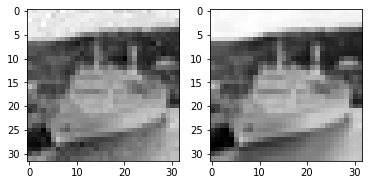

True label: 8
predicted label: 6
Time:  607.8179316520691  seconds
Generation 0
Max fitness value -0.5537749553914717
Generation 10
Max fitness value 0.9246676859628359
Generation 20
Max fitness value 0.9825951827896462
Generation 30
Max fitness value 0.9855270154961296
Generation 40
Max fitness value 0.9871699024065017
Generation 50
Max fitness value 0.9877951180887523
Generation 60
Max fitness value 0.988904833548049
Generation 70
Max fitness value 0.988904833548049
Generation 80
Max fitness value 0.9895756340985715
Generation 90
Max fitness value 0.989781266953647
Generation 100
Max fitness value 0.990135041840817
Generation 110
Max fitness value 0.990135041840817
Generation 120
Max fitness value 0.990135041840817
Generation 130
Max fitness value 0.990143412772042
Generation 140
Max fitness value 0.990143412772042
Generation 150
Max fitness value 0.990143412772042
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground tru

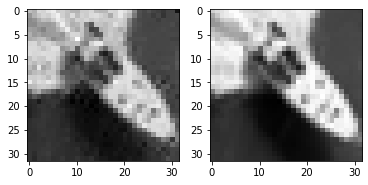

True label: 8
predicted label: 0
Time:  603.9505569934845  seconds
Generation 0
Max fitness value -0.6000287105519888
Generation 10
Max fitness value -0.6000287105519888
Generation 20
Max fitness value 0.9625835580170835
Generation 30
Max fitness value 0.9804036249613262
Generation 40
Max fitness value 0.9809273172974571
Generation 50
Max fitness value 0.9826230168715575
Generation 60
Max fitness value 0.98275204848135
Generation 70
Max fitness value 0.98275204848135
Generation 80
Max fitness value 0.98275204848135
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


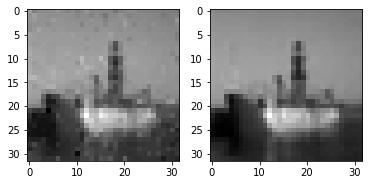

True label: 8
predicted label: 4
Time:  313.49778175354004  seconds
Generation 0
Max fitness value -0.5965750392437932
Generation 10
Max fitness value 0.9774710626202422
Generation 20
Max fitness value 0.9943946400366742
Generation 30
Max fitness value 0.9948959843176332
Generation 40
Max fitness value 0.994992093597166
Generation 50
Max fitness value 0.995157299853269
Generation 60
Max fitness value 0.995329598229074
Generation 70
Max fitness value 0.9953867903692546
Generation 80
Max fitness value 0.9954778388559916
Generation 90
Max fitness value 0.995491855009984
Generation 100
Max fitness value 0.995491855009984
Generation 110
Max fitness value 0.995491855009984
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


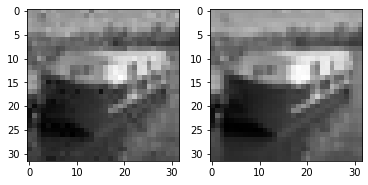

True label: 8
predicted label: 6
Time:  428.1931734085083  seconds
Generation 0
Max fitness value 0.2552098121274021
Generation 10
Max fitness value 0.9958272463366217
Generation 20
Max fitness value 0.996730407654267
Generation 30
Max fitness value 0.996730407654267
Generation 40
Max fitness value 0.996730407654267
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


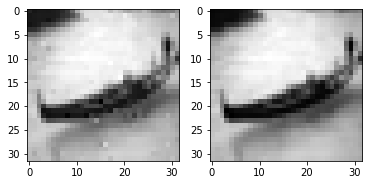

True label: 8
predicted label: 0
Time:  191.63763403892517  seconds
Generation 0
Max fitness value -0.5975883686764136
Generation 10
Max fitness value 0.9694286880750396
Generation 20
Max fitness value 0.9766186359578914
Generation 30
Max fitness value 0.9788964770406606
Generation 40
Max fitness value 0.9804662023580024
Generation 50
Max fitness value 0.9804662023580024
Generation 60
Max fitness value 0.9804662023580024
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


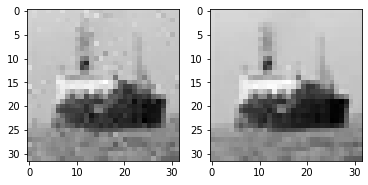

True label: 8
predicted label: 6
Time:  268.83423948287964  seconds
Generation 0
Max fitness value -0.6000245380546515
Generation 10
Max fitness value -0.6000245380546515
Generation 20
Max fitness value -0.6000245380546515
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


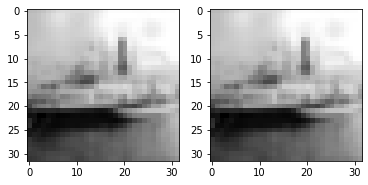

True label: 8
predicted label: 8
Time:  115.78543448448181  seconds
Generation 0
Max fitness value -0.5911433096696096
Generation 10
Max fitness value 0.9132396854242283
Generation 20
Max fitness value 0.9909970202396746
Generation 30
Max fitness value 0.994388562797054
Generation 40
Max fitness value 0.9951240783703809
Generation 50
Max fitness value 0.9954220441466739
Generation 60
Max fitness value 0.9956204128884951
Generation 70
Max fitness value 0.9956586167038648
Generation 80
Max fitness value 0.9957091815981814
Generation 90
Max fitness value 0.9958701237624673
Generation 100
Max fitness value 0.9958701237624673
Generation 110
Max fitness value 0.9958866771025761
Generation 120
Max fitness value 0.9960749183943786
Generation 130
Max fitness value 0.9960749183943786
Generation 140
Max fitness value 0.9960749183943786
Generation 150
Max fitness value 0.9960749183943786
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: g

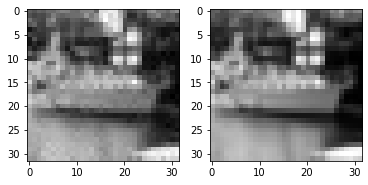

True label: 8
predicted label: 3
Time:  579.3171286582947  seconds
Generation 0
Max fitness value -0.6000595662621184
Generation 10
Max fitness value 0.9729094432250617
Generation 20
Max fitness value 0.9780602337533614
Generation 30
Max fitness value 0.9783265347877395
Generation 40
Max fitness value 0.9783265347877395
Generation 50
Max fitness value 0.9783265347877395
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


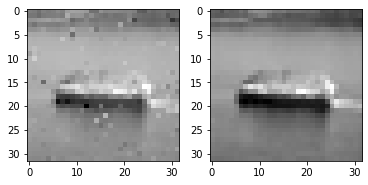

True label: 8
predicted label: 0
Time:  218.52874088287354  seconds
Generation 0
Max fitness value -0.5996373933104715
Generation 10
Max fitness value -0.4692015611080414
Generation 20
Max fitness value 0.8910213341610556
Generation 30
Max fitness value 0.991451711423303
Generation 40
Max fitness value 0.9957085592846805
Generation 50
Max fitness value 0.9959649897545728
Generation 60
Max fitness value 0.9962561478611937
Generation 70
Max fitness value 0.9964346880763757
Generation 80
Max fitness value 0.9965047752125176
Generation 90
Max fitness value 0.9966224779820461
Generation 100
Max fitness value 0.9966524156430662
Generation 110
Max fitness value 0.9966524156430662
Generation 120
Max fitness value 0.9966524156430662
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


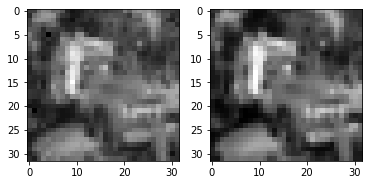

True label: 9
predicted label: 1
Time:  492.8333537578583  seconds
Generation 0
Max fitness value 0.3399016930245231
Generation 10
Max fitness value 0.9906028854216657
Generation 20
Max fitness value 0.9926930181155282
Generation 30
Max fitness value 0.9942686350532516
Generation 40
Max fitness value 0.994477318522314
Generation 50
Max fitness value 0.9949787083879159
Generation 60
Max fitness value 0.9951836473588448
Generation 70
Max fitness value 0.9957589398973662
Generation 80
Max fitness value 0.9961379396979787
Generation 90
Max fitness value 0.9963107359596475
Generation 100
Max fitness value 0.9966899150271238
Generation 110
Max fitness value 0.9967934508922316
Generation 120
Max fitness value 0.9967944542312956
Generation 130
Max fitness value 0.9968561549450883
Generation 140
Max fitness value 0.996886842509618
Generation 150
Max fitness value 0.9969538515557422
Generation 160
Max fitness value 0.996959690047588
Generation 170
Max fitness value 0.997048869618663
Generation 1

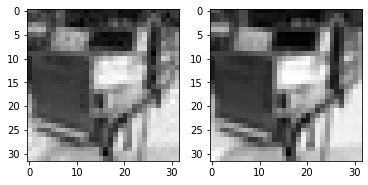

True label: 9
predicted label: 1
Time:  781.8107686042786  seconds
Generation 0
Max fitness value -0.5925601624306746
Generation 10
Max fitness value 0.8755946814847716
Generation 20
Max fitness value 0.9947923216745712
Generation 30
Max fitness value 0.9959013276316423
Generation 40
Max fitness value 0.9961030106821009
Generation 50
Max fitness value 0.9963819578381381
Generation 60
Max fitness value 0.9964229125099653
Generation 70
Max fitness value 0.9964633337961015
Generation 80
Max fitness value 0.9965925630808913
Generation 90
Max fitness value 0.9967243211256045
Generation 100
Max fitness value 0.9967456213372755
Generation 110
Max fitness value 0.9967740611149496
Generation 120
Max fitness value 0.9967740611149496
Generation 130
Max fitness value 0.9967740611149496
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


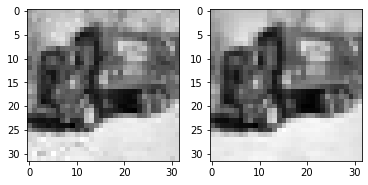

True label: 9
predicted label: 1
Time:  533.2387714385986  seconds
Generation 0
Max fitness value -0.5998983074496099
Generation 10
Max fitness value -0.08589082309149626
Generation 20
Max fitness value 0.981200879084593
Generation 30
Max fitness value 0.9840703084683108
Generation 40
Max fitness value 0.9863728684116869
Generation 50
Max fitness value 0.9871525792355651
Generation 60
Max fitness value 0.9872410420504881
Generation 70
Max fitness value 0.9872410420504881
Generation 80
Max fitness value 0.9874509645858024
Generation 90
Max fitness value 0.9876290965318506
Generation 100
Max fitness value 0.9884891247863229
Generation 110
Max fitness value 0.98857728403645
Generation 120
Max fitness value 0.9889267622116011
Generation 130
Max fitness value 0.988930552570232
Generation 140
Max fitness value 0.988930552570232
Generation 150
Max fitness value 0.988930552570232
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: groun

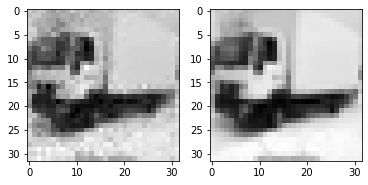

True label: 9
predicted label: 8
Time:  609.9052040576935  seconds
Generation 0
Max fitness value -0.5988443292980633
Generation 10
Max fitness value 0.8541694641898255
Generation 20
Max fitness value 0.9868819011368691
Generation 30
Max fitness value 0.9891019764190532
Generation 40
Max fitness value 0.9892130686218721
Generation 50
Max fitness value 0.9900220310222149
Generation 60
Max fitness value 0.9900283111758058
Generation 70
Max fitness value 0.9900283111758058
Generation 80
Max fitness value 0.9900283111758058
Generation 90
Max fitness value 0.9901785330198335
Generation 100
Max fitness value 0.9904165631557356
Generation 110
Max fitness value 0.9906138625684056
Generation 120
Max fitness value 0.9906138625684056
Generation 130
Max fitness value 0.9906138625684056
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


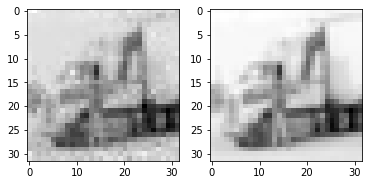

True label: 9
predicted label: 8
Time:  604.5317180156708  seconds
Generation 0
Max fitness value -0.6000157684436557
Generation 10
Max fitness value -0.6000157684436557
Generation 20
Max fitness value -0.6000157684436557
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


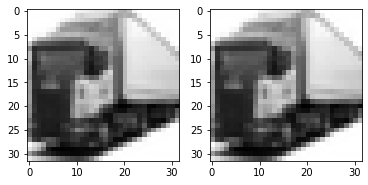

True label: 9
predicted label: 9
Time:  164.33239722251892  seconds
Generation 0
Max fitness value -0.22094983539925767
Generation 10
Max fitness value 0.967660797538996
Generation 20
Max fitness value 0.9903332522350257
Generation 30
Max fitness value 0.9916874651277908
Generation 40
Max fitness value 0.992322998322639
Generation 50
Max fitness value 0.992709496171251
Generation 60
Max fitness value 0.9934651347963045
Generation 70
Max fitness value 0.9936668108840777
Generation 80
Max fitness value 0.9938998549842408
Generation 90
Max fitness value 0.9944049353003737
Generation 100
Max fitness value 0.994577781481135
Generation 110
Max fitness value 0.9946626515058312
Generation 120
Max fitness value 0.9946932685321425
Generation 130
Max fitness value 0.994738639890714
Generation 140
Max fitness value 0.994738639890714
Generation 150
Max fitness value 0.994738639890714
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground

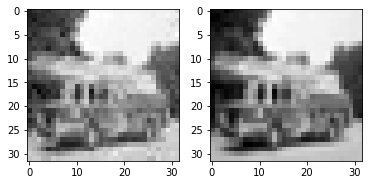

True label: 9
predicted label: 1
Time:  856.6032354831696  seconds
Generation 0
Max fitness value -0.5996838558952376
Generation 10
Max fitness value -0.30378221194801747
Generation 20
Max fitness value 0.9832654979870448
Generation 30
Max fitness value 0.9941770616766803
Generation 40
Max fitness value 0.9947587299464207
Generation 50
Max fitness value 0.994886361122912
Generation 60
Max fitness value 0.9951060859055066
Generation 70
Max fitness value 0.9952502062678985
Generation 80
Max fitness value 0.9953865958702504
Generation 90
Max fitness value 0.9955363332024169
Generation 100
Max fitness value 0.9956502531398566
Generation 110
Max fitness value 0.995680995845575
Generation 120
Max fitness value 0.9957677119785427
Generation 130
Max fitness value 0.9958810072425401
Generation 140
Max fitness value 0.9959667388052664
Generation 150
Max fitness value 0.9959857658210106
Generation 160
Max fitness value 0.9960935122927909
Generation 170
Max fitness value 0.9960935122927909
Generat

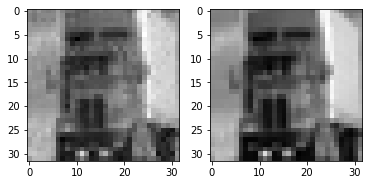

True label: 9
predicted label: 1
Time:  1044.3628487586975  seconds
Generation 0
Max fitness value -0.4072535241369456
Generation 10
Max fitness value 0.7315694844670232
Generation 20
Max fitness value 0.9783038440422503
Generation 30
Max fitness value 0.9940856354297852
Generation 40
Max fitness value 0.9951191523087061
Generation 50
Max fitness value 0.9954360355475956
Generation 60
Max fitness value 0.9958512822907661
Generation 70
Max fitness value 0.9959701928827362
Generation 80
Max fitness value 0.9960220060356586
Generation 90
Max fitness value 0.9961433035284246
Generation 100
Max fitness value 0.9961433035284246
Generation 110
Max fitness value 0.9961433035284246
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


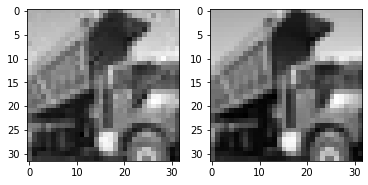

True label: 9
predicted label: 0
Time:  620.9032115936279  seconds
Generation 0
Max fitness value -0.5776297490440627
Generation 10
Max fitness value 0.8976545174974915
Generation 20
Max fitness value 0.993556665374956
Generation 30
Max fitness value 0.9949502465473389
Generation 40
Max fitness value 0.9950812432832981
Generation 50
Max fitness value 0.9952583660501071
Generation 60
Max fitness value 0.9953392523690068
Generation 70
Max fitness value 0.9955246071353936
Generation 80
Max fitness value 0.9956176030548518
Generation 90
Max fitness value 0.9957249752059836
Generation 100
Max fitness value 0.9957249752059836
Generation 110
Max fitness value 0.9957249752059836
Generation 120
Max fitness value 0.9958977546595601
Generation 130
Max fitness value 0.9958977546595601
Generation 140
Max fitness value 0.9958977546595601
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


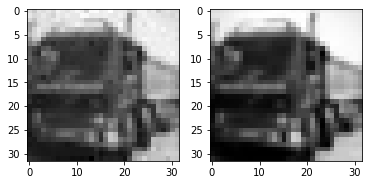

True label: 9
predicted label: 1
Time:  770.4580452442169  seconds
Generation 0
Max fitness value 0.5981534846985934
Generation 10
Max fitness value 0.9775875284189564
Generation 20
Max fitness value 0.9946247278672684
Generation 30
Max fitness value 0.9950549316884448
Generation 40
Max fitness value 0.9955073327873871
Generation 50
Max fitness value 0.9958120110222
Generation 60
Max fitness value 0.9958724366912798
Generation 70
Max fitness value 0.9958864617025034
Generation 80
Max fitness value 0.9960505821260344
Generation 90
Max fitness value 0.9961060724256459
Generation 100
Max fitness value 0.9961060724256459
Generation 110
Max fitness value 0.9961060724256459
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


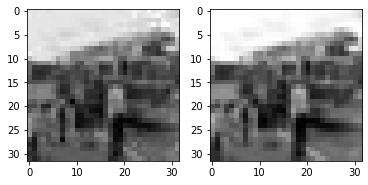

True label: 9
predicted label: 7
Time:  653.4006290435791  seconds
Generation 0
Max fitness value -0.5994698826196487
Generation 10
Max fitness value 0.9300887463504235
Generation 20
Max fitness value 0.99415329618743
Generation 30
Max fitness value 0.9944622552670211
Generation 40
Max fitness value 0.9947516673180841
Generation 50
Max fitness value 0.9948309291919728
Generation 60
Max fitness value 0.9948309291919728
Generation 70
Max fitness value 0.9948309291919728
Generation 80
Max fitness value 0.9948309291919728
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


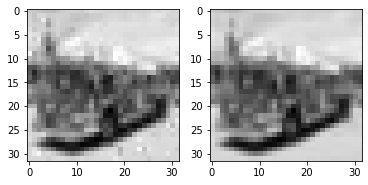

True label: 9
predicted label: 6
Time:  442.2499186992645  seconds
Generation 0
Max fitness value -0.5999883174241213
Generation 10
Max fitness value -0.598758129699353
Generation 20
Max fitness value 0.1883109099758077
Generation 30
Max fitness value 0.94926555172587
Generation 40
Max fitness value 0.9880522608389473
Generation 50
Max fitness value 0.9914165143389452
Generation 60
Max fitness value 0.9921963400907006
Generation 70
Max fitness value 0.9923808303186837
Generation 80
Max fitness value 0.9926761170509242
Generation 90
Max fitness value 0.9930466183115304
Generation 100
Max fitness value 0.9932301630588245
Generation 110
Max fitness value 0.9936576332838323
Generation 120
Max fitness value 0.9938490758496116
Generation 130
Max fitness value 0.9939146485691246
Generation 140
Max fitness value 0.9939146485691246
Generation 150
Max fitness value 0.9939549944178651
Generation 160
Max fitness value 0.9942299186013739
Generation 170
Max fitness value 0.9942991749314383
Generatio

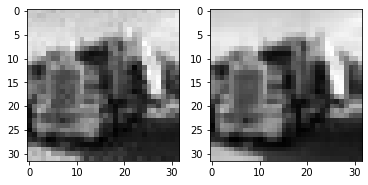

True label: 9
predicted label: 8
Time:  1028.9690170288086  seconds
FOUND ADVERSARIAL
Fitness of the adversarial 0.6525560523601718
Adversarial example image: 

Left: adversarial 	 Right: ground truth


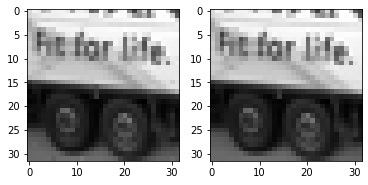

True label: 9
predicted label: 1
Time:  5.315065145492554  seconds


In [26]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  #print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)

  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = uniform(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [27]:
import pickle
file_ = open('GA_cifar_ssim_uniform', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 8776.401640415192
Min time: 5.315065145492554
Mean time: 539.6948362830886
Std time: 776.7678665928289

Max fitness evolved: 0.9992480068260192
Min fitness evolved:: -0.6036426394415755
Mean fitness evolved: 0.8791211604599933
Std fitness evolved:: 0.4007099918861135

Max ssim: 0.31891263081414545
Min ssim: 4.7814224184428156e-06
Mean ssim: 0.03648031588187864
Std ssim: 0.041302987422368306

Max round: 396
Min rounds: 0
Mean rounds: 113.32330827067669
Std rounds: 66.86183137125771

Percentage of adversarial founds sucessfully : 0.015037593984962405 %
Percentage of adversarial founds after fitness not improving for 30 generations: 0.9849624060150376 %


Open adversarial

In [20]:
with open('GA_cifar_ssim_uniform', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [21]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.9999719092126748
Min ssim: 0.6997527243063725
Mean ssim: 0.9594270743027448
Std ssim: 0.04437958341615912



In [24]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 
number_of_rounds

array([ 96,  67,  48, 155, 134,  47, 171, 254, 115,  43,  65,  50,  68,
       158,  66,  30,  68,  45,  95, 183,  55,  31,  63,  30,  30, 219,
        44,  50,  70, 157,  43,  56,  62, 153, 158,  50,  30,  30, 157,
        37,  57,  72, 117,  71,  79,  77,  53,  64,  65, 182,  59,  59,
       113,   1,  72,  89,  39,  47,  53,  35,  78, 105,  52,  98,  58,
        53,  46,  88,  66, 183,  54,  74,  96,  57, 166, 120, 105, 230,
       110,  52,  30,  76,  47, 232,  94, 128, 170,  77, 174, 105, 283,
        69, 109, 142,  49, 150,  80,  85,  87,  52,  55,  51, 102,  84,
       120,  73, 161, 127,  64, 147, 170, 166,  51, 126,  58,  63,  30,
        94,  49, 124, 141,  98,  56,  79,  30, 260, 165, 129, 104,   1,
        58, 173,  73])

In [25]:
print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")



Max round: 283
Min rounds: 1
Mean rounds: 92.47368421052632
Std rounds: 54.939690645571574



# Examples of what functions do

In [0]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

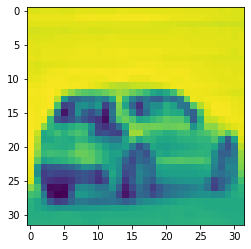

Class for this 1
[[2.2063480e-10 1.0000000e+00 6.6041472e-14 3.5760719e-12 3.9276270e-13
  1.1313486e-13 8.8119643e-13 6.8588521e-13 1.9681285e-13 3.7839783e-08]]


In [0]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [0]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


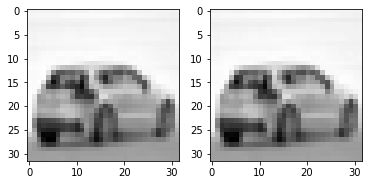

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [0]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


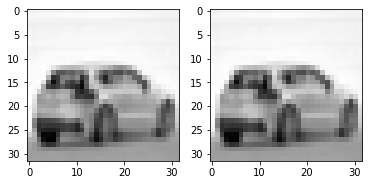

In [0]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [0]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

In [0]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


In [0]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


[-0.26002962878595726, -0.25999958545736684, -0.26007314251448344, -0.26004007622401076, -0.26003266487525345, -0.26011373574731095, -0.2599816460817825, -0.25998496480763594, -0.2600353571926644, -0.2600021864303609, -0.260040721413234, -0.2600228430135187, -0.26003768485830203, -0.26002701209750284, -0.26006302743228543, -0.2599796432991168, -0.2600043346069123, -0.26003024147792836, -0.2600466627237271, -0.26003812318804226, -0.2600652442884724, -0.2600447098702882, -0.2600085762943468, -0.26001327339828323, -0.2599806557454484, -0.26007237070197037, -0.25996000471207786, -0.2600457997287944, -0.2600101441535663, -0.26005323947618036, -0.2600554130353725, -0.2600860828123626, -0.26003997918862914, -0.26004537198733424, -0.2600515291553301, -0.2600503663988854, -0.26001231736237695, -0.2600170667581806, -0.2600851316879575, -0.2599960477747653, -0.260017809873727, -0.2600171997460062, -0.2600455137861651, -0.26001145913341955, -0.2600466317811507, -0.2600557191632309, -0.260061281083